# COVID-19 risk factors using TF-IDF

Approach:
1. Take title, abstract and text to cteate documnet
2. Simple preprocessing of documents
3. Find key words for each document. 
4. Calculate key words for each query sentence.
5. Calculate distance between query sentence and each document and select closest match as result


# Load libraries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import json
import math
import glob

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem.snowball import SnowballStemmer
from scipy.spatial import distance
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import ipywidgets as widgets

from IPython.display import Image
from IPython.display import display, HTML

# Load data into DF
In this part we will load data from both summary csv file and all availiable text / abstracts from additional .json files

In [2]:
root_dir = 'CORD-19-research-challenge'
#root_dir = 'CORD-19-research-challenge/2020-03-13'

In [3]:
df = pd.read_csv(f'{root_dir}/metadata.csv')
doc_paths = glob.glob(f'{root_dir}/*/*/*.json')
df.sha.fillna("", inplace=True)

#get text for articles that are available
def get_text(sha):
    if sha == "":
        return ""
    document_path = [x for x in doc_paths if sha in x]
    if not document_path:
        return ""
    with open(document_path[0]) as f:
        file = json.load(f)
        full_text = []
        #iterate over abstract and body part
        for part in ['abstract', 'body_text']:
            # iterate over each paragraph
            for text_part in file[part]:
                text = text_part['text']
                # remove citations from each paragraph
                for citation in text_part['cite_spans']:
                    text = text.replace(citation['text'], "")
                full_text.append(text)
            
        return str.join(' ', full_text)
%time df['text'] = df.apply(lambda x: get_text(x.sha), axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Wall time: 1.88 s


In [4]:
df.head()
df.to_csv('paper.csv', header=True, index=False)

# Preprocessing data

preprocess text. First change all letters to lower case, then we apply stemming and remove stopwords afterwards. 

(note) Lemmatization is also valid approach, and might increase accuracy later on, but it could also reduce accuracy. 

In [5]:
analyzer = CountVectorizer().build_analyzer()
stemmer = SnowballStemmer("english")

def preprocess(doc):
    doc=doc.lower()
    return str.join(" ", [stemmer.stem(w) for w in analyzer(doc)])

def preprocess_row(row):
    text = str.join(' ', [str(row.title), str(row.abstract), str(row.text)])
    return preprocess(text)

%time df['preprocessed'] = df.apply(lambda x: preprocess_row(x), axis=1)

Wall time: 3min 23s


# Apply TF-IDF
Calculate number of words then use TF_IDF approach.
- TF(w) = (Number of times term w appears in a document) / (Total number of terms in the document)
- IDF(w) = log_e(Total number of documents / Number of documents with term w in it)

In [6]:
cv = CountVectorizer(max_df=0.95, stop_words='english')
%time word_count = cv.fit_transform(df.preprocessed)
tfidf_tr = TfidfTransformer(smooth_idf=True, use_idf=True)
%time tfidf_tr.fit(word_count)

Wall time: 11.2 s
Wall time: 54.1 ms


TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

create word vector for all documents

In [7]:
def get_word_vector(document):
    w_vector = tfidf_tr.transform(cv.transform([document]))
    return w_vector 

%time df['word_vector'] = df.preprocessed.apply(get_word_vector)

Wall time: 2min


calcululate distance between each document and the searching document(phrase) using only words that were in query documnet(phrase)

# Calculate distance between searching phrase and each document

In [8]:
def show_word_cloud(word_vector):
    cloud = WordCloud(background_color='white',
        width=500,
        height=500,
        max_words=20,
        colormap='tab10',
        prefer_horizontal=1.0)
    word_frequency = dict(get_words_with_value(word_vector))
    cloud.generate_from_frequencies(word_frequency)
    plt.gca().imshow(cloud)
    plt.gca().axis('off')

feature_names = cv.get_feature_names()
def get_words_with_value(w_vector):
    return sorted([(feature_names[ind], val) for ind, val in zip(w_vector.indices, w_vector.data)], key=lambda x: x[1], reverse=True)

In [9]:
def calculate_distance_between_words_vectors(search_words_indices, search_vec, document_vector):
    document_vec = document_vector[0, search_words_indices].toarray()
    return distance.euclidean(search_vec, document_vec)

def get_related_documents(text, number_of_documents):    
    search_vector = get_word_vector(preprocess(text))
    search_words_indices = search_vector.indices
    search_vec = search_vector[0, search_words_indices].toarray()
    distance_idx = df.apply(lambda x: calculate_distance_between_words_vectors(search_words_indices, search_vec, x.word_vector), axis=1)
    relevant_indexes = distance_idx.sort_values().head(number_of_documents).index 
    result_columns = ["title", "doi", "pmcid", "pubmed_id", "license", "authors", "word_vector"]
    result = df[result_columns].iloc[relevant_indexes].fillna("")
    return result

# Results

In [10]:
tasks = {
    "What is known about transmission, incubation, and environmental stability?" :
    [
        "Range of incubation periods for the disease in humans (and how this varies across age and health status) and how long individuals are contagious, even after recovery.",
        "Prevalence of asymptomatic shedding and transmission (e.g., particularly children).",
        "Seasonality of transmission.",
        "Physical science of the coronavirus (e.g., charge distribution, adhesion to hydrophilic/phobic surfaces, environmental survival to inform decontamination efforts for affected areas and provide information about viral shedding).",
        "Persistence and stability on a multitude of substrates and sources (e.g., nasal discharge, sputum, urine, fecal matter, blood).",
        "Persistence of virus on surfaces of different materials (e,g., copper, stainless steel, plastic).",
        "Natural history of the virus and shedding of it from an infected person",
        "Implementation of diagnostics and products to improve clinical processes",
        "Disease models, including animal models for infection, disease and transmission",
        "Tools and studies to monitor phenotypic change and potential adaptation of the virus",
        "Immune response and immunity",
        "Effectiveness of movement control strategies to prevent secondary transmission in health care and community settings",
        "Effectiveness of personal protective equipment (PPE) and its usefulness to reduce risk of transmission in health care and community settings",
        "Role of the environment in transmission"
    ],
    "What do we know about COVID-19 risk factors?":
    [
        "Data on potential risks factors",
        "Smoking, pre-existing pulmonary disease",
        "Co-infections (determine whether co-existing respiratory/viral infections make the virus more transmissible or virulent) and other co-morbidities",
        "Neonates and pregnant women",
        "Socio-economic and behavioral factors to understand the economic impact of the virus and whether there were differences.",
        "Transmission dynamics of the virus, including the basic reproductive number, incubation period, serial interval, modes of transmission and environmental factors",
        "Severity of disease, including risk of fatality among symptomatic hospitalized patients, and high-risk patient groups",
        "Susceptibility of populations",
        "Public health mitigation measures that could be effective for control"
    ],
    "What do we know about virus genetics, origin, and evolution?":
    [
        "Real-time tracking of whole genomes and a mechanism for coordinating the rapid dissemination of that information to inform the development of diagnostics and therapeutics and to track variations of the virus over time.",
        "Access to geographic and temporal diverse sample sets to understand geographic distribution and genomic differences, and determine whether there is more than one strain in circulation. Multi-lateral agreements such as the Nagoya Protocol could be leveraged.",
        "Evidence that livestock could be infected (e.g., field surveillance, genetic sequencing, receptor binding) and serve as a reservoir after the epidemic appears to be over.",
        "Evidence of whether farmers are infected, and whether farmers could have played a role in the origin.",
        "Surveillance of mixed wildlife- livestock farms for SARS-CoV-2 and other coronaviruses in Southeast Asia.",
        "Experimental infections to test host range for this pathogen.",
        "Animal host(s) and any evidence of continued spill-over to humans",
        "Socioeconomic and behavioral risk factors for this spill-over",
        "Sustainable risk reduction strategies"
    ],
    "What do we know about vaccines and therapeutics?":
    [
        "Effectiveness of drugs being developed and tried to treat COVID-19 patients.",
        "Clinical and bench trials to investigate less common viral inhibitors against COVID-19 such as naproxen, clarithromycin, and minocyclinethat that may exert effects on viral replication.",
        "Methods evaluating potential complication of Antibody-Dependent Enhancement (ADE) in vaccine recipients.",
        "Exploration of use of best animal models and their predictive value for a human vaccine.",
        "Capabilities to discover a therapeutic (not vaccine) for the disease, and clinical effectiveness studies to discover therapeutics, to include antiviral agents.",
        "Alternative models to aid decision makers in determining how to prioritize and distribute scarce, newly proven therapeutics as production ramps up. This could include identifying approaches for expanding production capacity to ensure equitable and timely distribution to populations in need.",
        "Efforts targeted at a universal coronavirus vaccine.",
        "Efforts to develop animal models and standardize challenge studies",
        "Efforts to develop prophylaxis clinical studies and prioritize in healthcare workers",
        "Approaches to evaluate risk for enhanced disease after vaccination",
        "Assays to evaluate vaccine immune response and process development for vaccines, alongside suitable animal models [in conjunction with therapeutics],",
    ],
    "What do we know about diagnostics and surveillance?":
    [
        "How widespread current exposure is to be able to make immediate policy recommendations on mitigation measures. Denominators for testing and a mechanism for rapidly sharing that information, including demographics, to the extent possible. Sampling methods to determine asymptomatic disease (e.g., use of serosurveys (such as convalescent samples) and early detection of disease (e.g., use of screening of neutralizing antibodies such as ELISAs).",
        "Efforts to increase capacity on existing diagnostic platforms and tap into existing surveillance platforms.",
        "Recruitment, support, and coordination of local expertise and capacity (public, private—commercial, and non-profit, including academic), including legal, ethical, communications, and operational issues.",
        "National guidance and guidelines about best practices to states (e.g., how states might leverage universities and private laboratories for testing purposes, communications to public health officials and the public).",
        "Development of a point-of-care test (like a rapid influenza test) and rapid bed-side tests, recognizing the tradeoffs between speed, accessibility, and accuracy.",
        "Rapid design and execution of targeted surveillance experiments calling for all potential testers using PCR in a defined area to start testing and report to a specific entity. These experiments could aid in collecting longitudinal samples, which are critical to understanding the impact of ad hoc local interventions (which also need to be recorded).",
        "Separation of assay development issues from instruments, and the role of the private sector to help quickly migrate assays onto those devices.",
        "Efforts to track the evolution of the virus (i.e., genetic drift or mutations) and avoid locking into specific reagents and surveillance/detection schemes.",
        "Latency issues and when there is sufficient viral load to detect the pathogen, and understanding of what is needed in terms of biological and environmental sampling.",
        "Use of diagnostics such as host response markers (e.g., cytokines) to detect early disease or predict severe disease progression, which would be important to understanding best clinical practice and efficacy of therapeutic interventions.",
        "Policies and protocols for screening and testing.",
        "Policies to mitigate the effects on supplies associated with mass testing, including swabs and reagents.",
        "Technology roadmap for diagnostics.",
        "Barriers to developing and scaling up new diagnostic tests (e.g., market forces), how future coalition and accelerator models (e.g., Coalition for Epidemic Preparedness Innovations) could provide critical funding for diagnostics, and opportunities for a streamlined regulatory environment.",
        "New platforms and technology (e.g., CRISPR) to improve response times and employ more holistic approaches to COVID-19 and future diseases.",
        "Coupling genomics and diagnostic testing on a large scale.",
        "Enhance capabilities for rapid sequencing and bioinformatics to target regions of the genome that will allow specificity for a particular variant.",
        "Enhance capacity (people, technology, data) for sequencing with advanced analytics for unknown pathogens, and explore capabilities for distinguishing naturally-occurring pathogens from intentional.",
        "One Health surveillance of humans and potential sources of future spillover or ongoing exposure for this organism and future pathogens, including both evolutionary hosts (e.g., bats) and transmission hosts (e.g., heavily trafficked and farmed wildlife and domestic food and companion species), inclusive of environmental, demographic, and occupational risk factors."
    ],
    "What do we know about non-pharmaceutical interventions?":
    [
        "Guidance on ways to scale up NPIs in a more coordinated way (e.g., establish funding, infrastructure and authorities to support real time, authoritative (qualified participants) collaboration with all states to gain consensus on consistent guidance and to mobilize resources to geographic areas where critical shortfalls are identified) to give us time to enhance our health care delivery system capacity to respond to an increase in cases.",
        "Rapid design and execution of experiments to examine and compare NPIs currently being implemented. DHS Centers for Excellence could potentially be leveraged to conduct these experiments.",
        "Rapid assessment of the likely efficacy of school closures, travel bans, bans on mass gatherings of various sizes, and other social distancing approaches.",
        "Methods to control the spread in communities, barriers to compliance and how these vary among different populations.",
        "Models of potential interventions to predict costs and benefits that take account of such factors as race, income, disability, age, geographic location, immigration status, housing status, employment status, and health insurance status.",
        "Policy changes necessary to enable the compliance of individuals with limited resources and the underserved with NPIs.",
        "Research on why people fail to comply with public health advice, even if they want to do so (e.g., social or financial costs may be too high).",
        "Research on the economic impact of this or any pandemic. This would include identifying policy and programmatic alternatives that lessen/mitigate risks to critical government services, food distribution and supplies, access to critical household supplies, and access to health diagnoses, treatment, and needed care, regardless of ability to pay."
    ],
    "What has been published about medical care?":
    [
        "Resources to support skilled nursing facilities and long term care facilities.",
        "Mobilization of surge medical staff to address shortages in overwhelmed communities",
        "Age-adjusted mortality data for Acute Respiratory Distress Syndrome (ARDS) with/without other organ failure – particularly for viral etiologies",
        "Extracorporeal membrane oxygenation (ECMO) outcomes data of COVID-19 patients",
        "Outcomes data for COVID-19 after mechanical ventilation adjusted for age.",
        "Knowledge of the frequency, manifestations, and course of extrapulmonary manifestations of COVID-19, including, but not limited to, possible cardiomyopathy and cardiac arrest.",
        "Application of regulatory standards (e.g., EUA, CLIA) and ability to adapt care to crisis standards of care level.",
        "Approaches for encouraging and facilitating the production of elastomeric respirators, which can save thousands of N95 masks.",
        "Best telemedicine practices, barriers and faciitators, and specific actions to remove/expand them within and across state boundaries.",
        "Guidance on the simple things people can do at home to take care of sick people and manage disease.",
        "Oral medications that might potentially work.",
        "Use of AI in real-time health care delivery to evaluate interventions, risk factors, and outcomes in a way that could not be done manually.",
        "Best practices and critical challenges and innovative solutions and technologies in hospital flow and organization, workforce protection, workforce allocation, community-based support resources, payment, and supply chain management to enhance capacity, efficiency, and outcomes.",
        "Efforts to define the natural history of disease to inform clinical care, public health interventions, infection prevention control, transmission, and clinical trials",
        "Efforts to develop a core clinical outcome set to maximize usability of data across a range of trials",
        "Efforts to determine adjunctive and supportive interventions that can improve the clinical outcomes of infected patients (e.g. steroids, high flow oxygen)"
    ],
    "What has been published about information sharing and inter-sectoral collaboration?":
    [
        "Methods for coordinating data-gathering with standardized nomenclature.",
        "Sharing response information among planners, providers, and others.",
        "Understanding and mitigating barriers to information-sharing.",
        "How to recruit, support, and coordinate local (non-Federal) expertise and capacity relevant to public health emergency response (public, private, commercial and non-profit, including academic).",
        "Integration of federal/state/local public health surveillance systems.",
        "Value of investments in baseline public health response infrastructure preparedness",
        "Modes of communicating with target high-risk populations (elderly, health care workers).",
        "Risk communication and guidelines that are easy to understand and follow (include targeting at risk populations’ families too).",
        "Communication that indicates potential risk of disease to all population groups.",
        "Misunderstanding around containment and mitigation.",
        "Action plan to mitigate gaps and problems of inequity in the Nation’s public health capability, capacity, and funding to ensure all citizens in need are supported and can access information, surveillance, and treatment.",
        "Measures to reach marginalized and disadvantaged populations.",
        "Data systems and research priorities and agendas incorporate attention to the needs and circumstances of disadvantaged populations and underrepresented minorities.",
        "Mitigating threats to incarcerated people from COVID-19, assuring access to information, prevention, diagnosis, and treatment.",
        "Understanding coverage policies (barriers and opportunities) related to testing, treatment, and care"
    ],
    "What has been published about ethical and social science considerations?":
    [
        "Efforts to articulate and translate existing ethical principles and standards to salient issues in COVID-2019",
        "Efforts to embed ethics across all thematic areas, engage with novel ethical issues that arise and coordinate to minimize duplication of oversight",
        "Efforts to support sustained education, access, and capacity building in the area of ethics",
        "Efforts to establish a team at WHO that will be integrated within multidisciplinary research and operational platforms and that will connect with existing and expanded global networks of social sciences.",
        "Efforts to develop qualitative assessment frameworks to systematically collect information related to local barriers and enablers for the uptake and adherence to public health measures for prevention and control. This includes the rapid identification of the secondary impacts of these measures. (e.g. use of surgical masks, modification of health seeking behaviors for SRH, school closures)",
        "Efforts to identify how the burden of responding to the outbreak and implementing public health measures affects the physical and psychological health of those providing care for Covid-19 patients and identify the immediate needs that must be addressed.",
        "Efforts to identify the underlying drivers of fear, anxiety and stigma that fuel misinformation and rumor, particularly through social media.",
    ]
}

Helper functions for displaying everything

In [11]:
def display_friendly_results(df_result):
    display_columns = ["title", "doi", "pmcid", "pubmed_id", "authors"]
    display(df_result[display_columns].reset_index(drop=True))
    rows = math.ceil(len(df_result)/3)
    plt.rcParams["figure.figsize"] = (20,15)
    for i in range(len(df_result)):
        row = df_result.iloc[1]
        plt.subplot(rows, 3, i+1)
        show_word_cloud(row.word_vector)
        plt.title(f'Paper {i}', fontsize=20)
    plt.show()

def display_topics_results(task):
    for topic in tasks[task]:
        display(HTML(f"<h3>{topic}<h3>"))
        topic_result = get_related_documents(topic, 6)
        display_friendly_results(topic_result)

# What is known about transmission, incubation, and environmental stability?

title  \
0  A Generalized Discrete Dynamic Model for Human...   
1  A simulation of a COVID-19 epidemic based on a...   
2  Relapsing and remitting viral diseases of the ...   
3  The Novel Coronavirus, 2019-nCoV, is Highly Co...   
4  The Novel Coronavirus, 2019-nCoV, is Highly Co...   
5  Incubation Period of Shiga Toxin–Producing Esc...   

                             doi       pmcid    pubmed_id  \
0      10.1101/2020.02.11.944728                            
1    10.1101/2020.04.20.20072272                            
2  10.1016/s0166-2236(84)80191-5                            
3    10.1101/2020.02.07.20021154                            
4                                                           
5          10.1093/epirev/mxz001  PMC7108491  3.16169e+07   

                                             authors  
0  Wenjun Zhang; Zeliang Chen; Yi Lu; Zhongmin Gu...  
1                                   Jose' M Carcione  
2                                Johnson, Richard T.  
3  Steven Sanche; Yen Ting Lin; Chonggang Xu; Eth...  
4  Steven Sanche; Yen Lin Ting; Chonggang Xu; Eth...  
5  Awofisayo-Okuyelu, Adedoyin; Brainard, Julii; ...

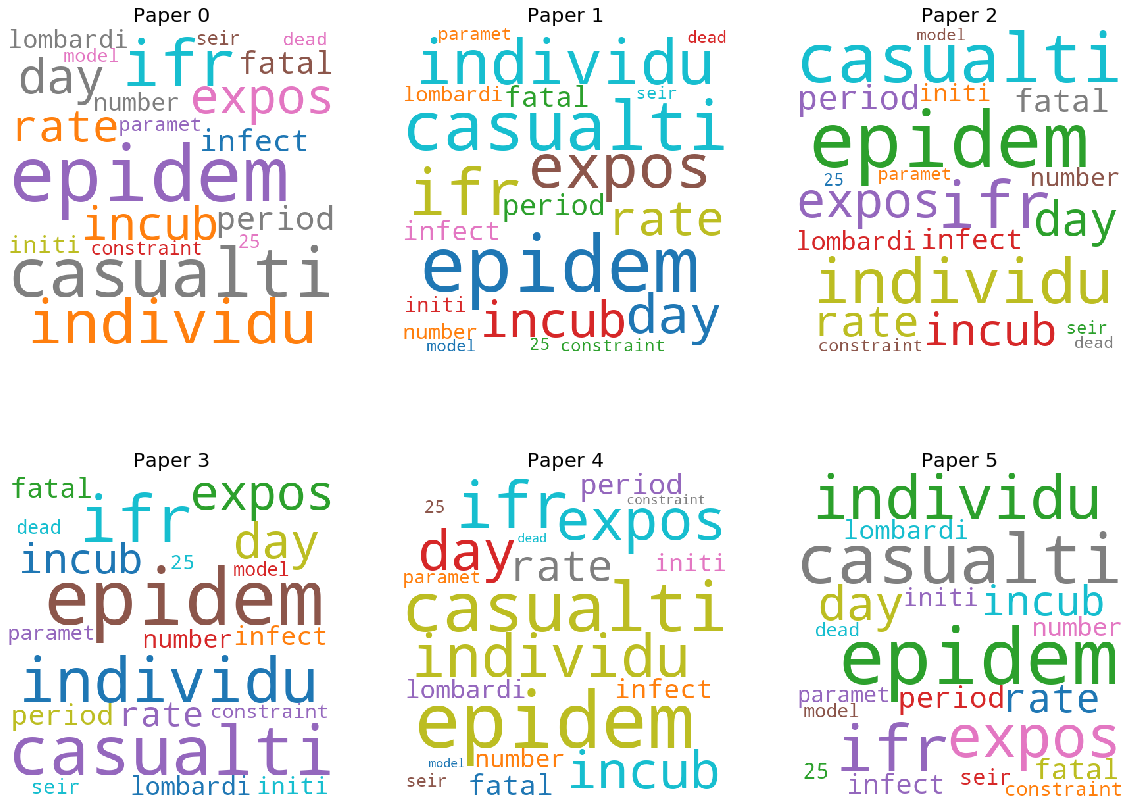

title  \
0  Detection of Respiratory Viruses in Asymptomat...   
1  Shedding of coronavirus‐like particles by chil...   
2  Asymptomatic Shedding of Respiratory Virus amo...   
3  Respiratory Pathogens in Children with and wit...   
4  Respiratory Virus Shedding in a Cohort of On-D...   
5  Carriage of Mycoplasma pneumoniae in the Upper...   

                            doi       pmcid   pubmed_id  \
0             10.1002/pbc.24314  PMC3502722  22987475.0   
1        10.1002/jmv.1890270219  PMC7166612   2921603.0   
2      10.1128/msphere.00249-18  PMC6041500  29997120.0   
3   10.1016/j.jpeds.2008.08.036  PMC7094528  18823911.0   
4                10.1086/669857  PMC3730277  23466910.0   
5  10.1371/journal.pmed.1001444  PMC3653782  23690754.0   

                                             authors  
0  Srinivasan, Ashok; Flynn, Patricia; Gu, Zhengm...  
1      Kidd, A. H.; Esrey, S. A.; Ujfalusi, Maria J.  
2  Birger, Ruthie; Morita, Haruka; Comito, Devon;...  
3  van der Zalm, Marieke M.; van Ewijk, Bart E.; ...  
4  Esbenshade, Jennifer C.; Edwards, Kathryn M.; ...  
5  Spuesens, Emiel B. M.; Fraaij, Pieter L. A.; V...

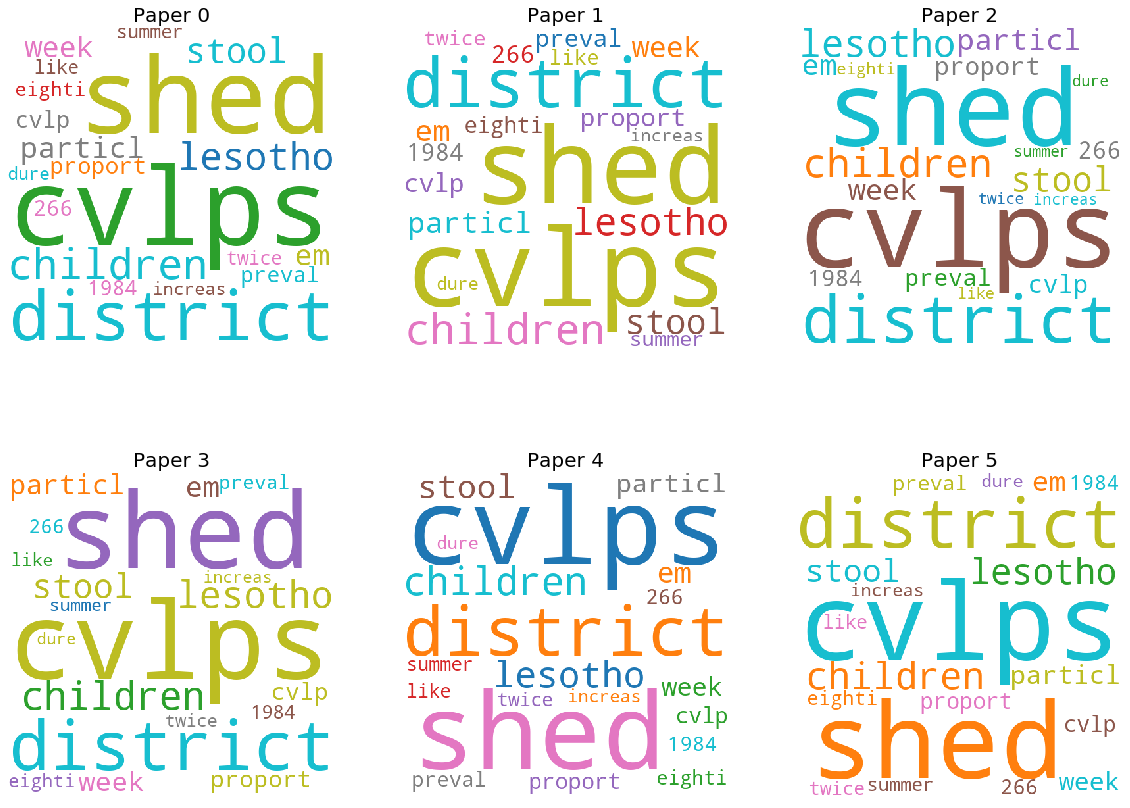

title  \
0  O.7.5 Human bocavirus infections have seasonal...   
1  Potential impact of seasonal forcing on a SARS...   
2        Network Analysis of Global Influenza Spread   
3  Characterising the epidemic spread of Influenz...   
4  Potential impact of seasonal forcing on a SARS...   
5  Modeling the variations in pediatric respirato...   

                             doi       pmcid    pubmed_id  \
0  10.1016/s1386-6532(08)70060-x                            
1    10.1101/2020.02.13.20022806                            
2   10.1371/journal.pcbi.1001005  PMC2987833  2.11249e+07   
3      10.1101/2020.04.27.052225                            
4         10.4414/smw.2020.20224                            
5       10.1186/1471-2334-11-105  PMC3094225  2.15109e+07   

                                             authors  
0  Waris, M.; Ylinen, T.; Ruuskanen, O.; Heikkine...  
1  Richard A Neher; Robert Dyrdak; Valentin Druel...  
2        Chan, Joseph; Holmes, Antony; Rabadan, Raul  
3  Nicola Felix Müller; Daniel Wüthrich; Nina Gol...  
4  Neher, Richard A.; Dyrdak, Robert; Druelle, Va...  
5  Leecaster, Molly; Gesteland, Per; Greene, Tom;...

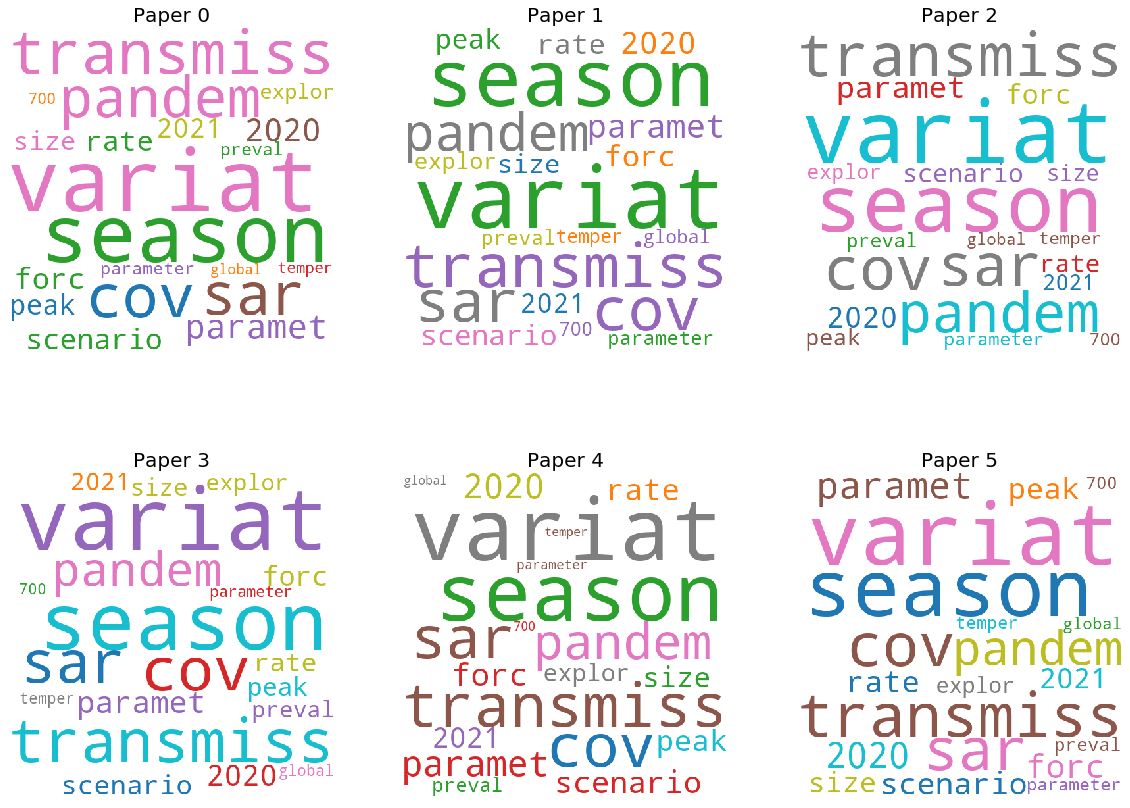

title  \
0        Chapter 13 Epidemiology of Viral Infections   
1  An Efficient Ethanol-Vacuum Method for the Dec...   
2  Chapter 12 Next generation agents (synthetic a...   
3  Generic aspects of the airborne spread of huma...   
4  Recharging improves efficiency of decontaminat...   
5  COVID-19 Global Pandemic Planning: Decontamina...   

                                  doi       pmcid    pubmed_id  \
0  10.1016/b978-0-12-375156-0.00013-8  PMC7150207                
1         10.1101/2020.04.12.20059709                            
2  10.1016/b978-0-12-812026-2.00012-8  PMC7153315                
3          10.1016/j.ajic.2016.06.008  PMC7115269  2.75907e+07   
4                                                                
5         10.1101/2020.04.09.20060129                            

                                             authors  
0  Burrell, Christopher J.; Howard, Colin R.; Mur...  
1  Albert I. Nazeeri; Isaac A. Hilburn; Daw-An Wu...  
2  Sharma, Anshula; Gupta, Gaganjot; Ahmad, Tawse...  
3  Ijaz, M. Khalid; Zargar, Bahram; Wright, Kathr...  
4  Emroj Hossain; Satyanu Bhadra; Harsh Jain; Arn...  
5  Douglas Jay Perkins; Steven Villescas; Terry H...

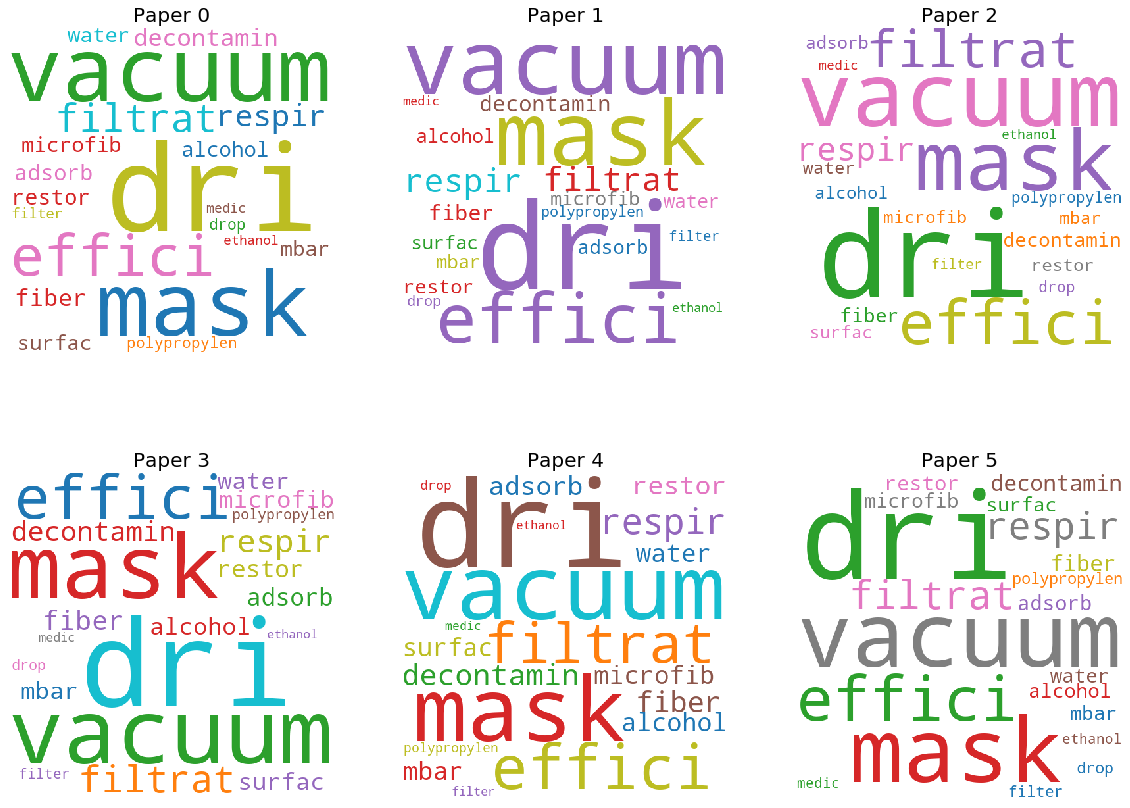

title  \
0  Viral Kinetics and Antibody Responses in Patie...   
1  Virus shedding patterns in nasopharyngeal and ...   
2  A long-term animal experiment indicating persi...   
3  Recreational ‘mud fever’: Leptospira interroga...   
4  Evaluation of SARS-CoV-2 RNA shedding in clini...   
5  The potential of molecular diagnostics and ser...   

                                  doi       pmcid    pubmed_id  \
0         10.1101/2020.03.24.20042382                            
1         10.1101/2020.03.28.20043059                            
2                10.1292/jvms.18-0050  PMC6068295    2.978e+07   
3          10.1016/j.idcr.2019.e00529  PMC6441746  3.09765e+07   
4                  10.7150/ijbs.45357  PMC7098032                
5  10.1016/j.diagmicrobio.2016.06.008  PMC7126930  2.73777e+07   

                                             authors  
0  Wenting Tan; Yanqiu Lu; Juan Zhang; Jing Wang;...  
1  Ning Zhang; Yuhuan Gong; Fanping Meng; Yuhai B...  
2  KANNO, Toru; ISHIHARA, Ryoko; HATAMA, Shinichi...  
3  Schmalzle, Sarah A; Tabatabai, Ali; Mazzeffi, ...  
4  Lo, Iek Long; Lio, Chon Fu; Cheong, Hou Hon; L...  
5  Gilbert, David; Gelfer, Gita; Wang, Lian; Myer...

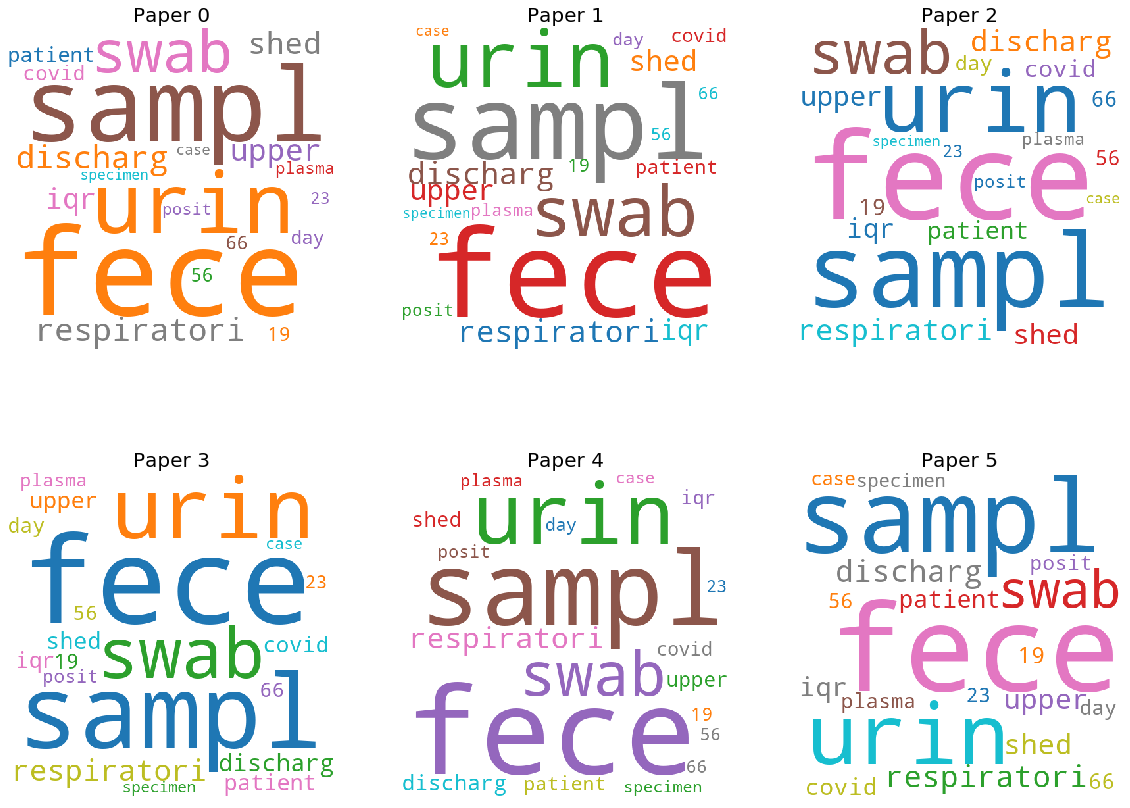

title  \
0  Survival of porcine epidemic diarrhea virus (P...   
1  Human Coronavirus 229E Remains Infectious on C...   
2  Inactivation of Murine Norovirus on a Range of...   
3    Effects of temperature on COVID-19 transmission   
4  Maintenance of influenza virus infectivity on ...   
5  Decontamination of Bacillus subtilis var. nige...   

                           doi       pmcid    pubmed_id  \
0    10.1186/s40813-017-0064-3  PMC5604292  2.89324e+07   
1        10.1128/mbio.01697-15  PMC4659470  2.65563e+07   
2         10.1128/aem.03280-14  PMC4292492  2.54523e+07   
3  10.1101/2020.03.29.20044461                            
4    10.1007/s12199-010-0149-y  PMC2955907  2.14326e+07   
5        10.1631/jzus.b1100289  PMC3323940  2.24674e+07   

                                             authors  
0  Trudeau, Michaela P.; Verma, Harsha; Urriola, ...  
1  Warnes, Sarah L.; Little, Zoë R.; Keevil, C. W...  
2  Warnes, Sarah L.; Summersgill, Emma N.; Keevil...  
3  shrikant pawar; Aditya Stanam; Mamata Chaudhar...  
4  Sakaguchi, Hiroko; Wada, Koji; Kajioka, Jitsuo...  
5  Li, Yan-ju; Zhu, Neng; Jia, Hai-quan; Wu, Jin-...

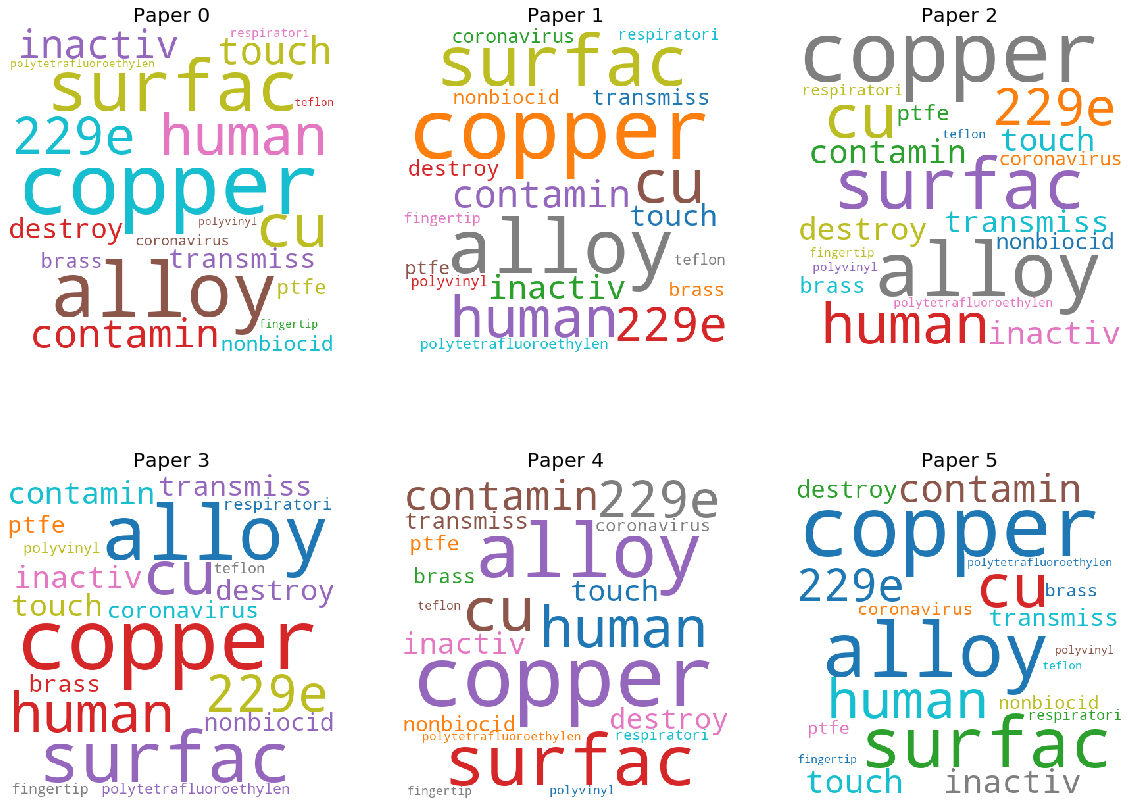

title  \
0  CHAPTER 56 Epidemiology, Natural History and T...   
1  Viral shedding and clinical illness in natural...   
2  Chapter 4 The natural history of multiple scle...   
3  31 Infections and Asthma Impact on the Natural...   
4                    Chapter 1 The Nature of Viruses   
5  The Early Natural History of SARS-CoV-2 Infect...   

                                  doi       pmcid    pubmed_id  \
0  10.1016/b978-1-4160-2882-6.50060-5  PMC7151785                
1                      10.1086/652241  PMC3060408  2.03774e+07   
2  10.1016/b978-0-443-07271-0.50006-9  PMC7173457                
3  10.1016/b978-0-323-29875-9.00031-8                            
4  10.1016/b978-0-12-800946-8.00001-5  PMC7148634                
5        10.1016/j.mayocp.2020.04.010                            

                                             authors  
0                    van der Loeff, Maarten F. Schim  
1  Lau, Lincoln L. H.; Cowling, Benjamin J.; Fang...  
2          Confavreux, Christian; Compston, Alastair  
3  Jackson, Daniel J.; Lemanske, Robert F.; Gern,...  
4                                                     
5  Cohen, Pieter A.; Hall, Lara; Johns, Janice N....

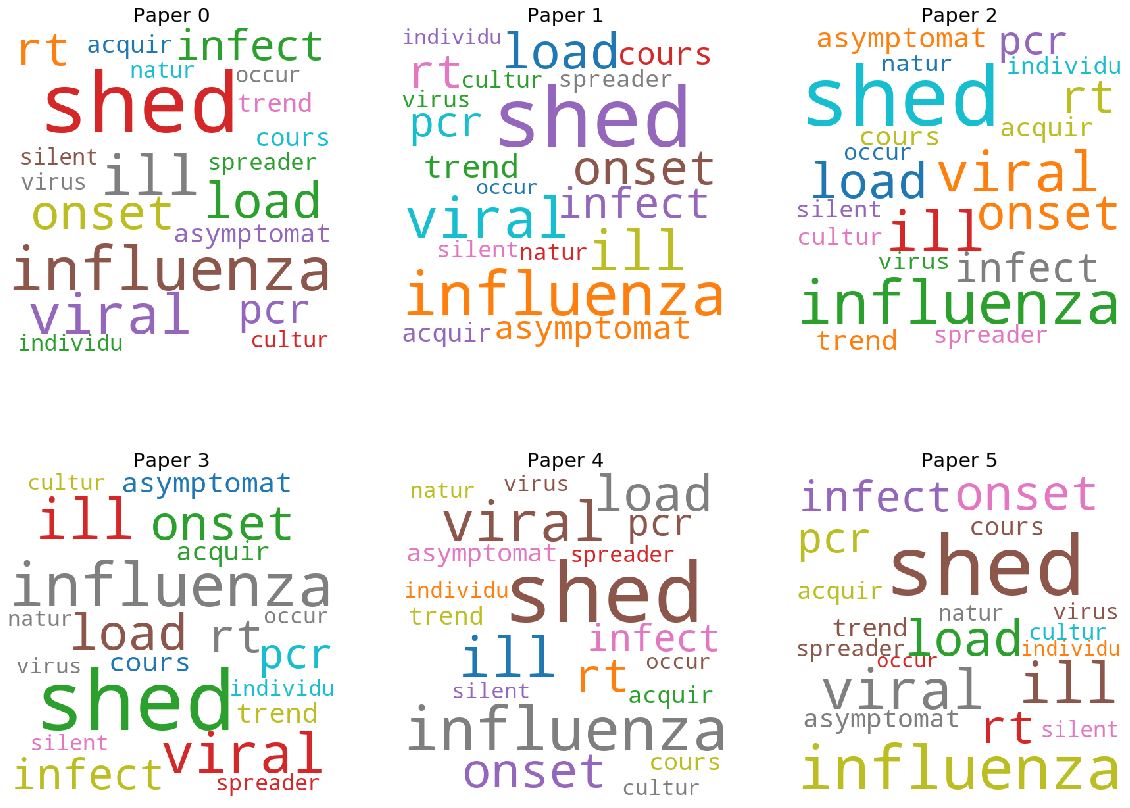

title  \
0  O486 Implementation of a real-time RT-PCR assa...   
1             Epidemiology of Respiratory Infections   
2  Impact of the implementation of a respiratory ...   
3  Deep Learning-Based Method of Diagnosing Hyper...   
4  National Institutes of Health–Sponsored Clinic...   
5  Public Health Laboratory System Improvement Pr...   

                             doi       pmcid    pubmed_id  \
0  10.1016/s0924-8579(07)70330-8                            
1   10.1007/978-3-030-26961-6_28  PMC7120591                
2      10.1016/j.jcv.2015.07.028  PMC7129648                
3           10.2147/dmso.s242585  PMC7073442                
4              10.2337/db16-0234  PMC5079635  2.74652e+07   
5                                 PMC2846800  2.05184e+07   

                                             authors  
0  Dumoulin, A.; Marti, H.P.; Panning, M.; Hirsch...  
1     Avendaño Carvajal, Luis; Perret Pérez, Cecilia  
2  De Keukeleire, S.; Descheemaeker, P.; Devinck,...  
3  Liu, Yuliang; Zhang, Quan; Zhao, Geng; Liu, Gu...  
4  Ricordi, Camillo; Goldstein, Julia S.; Balamur...  
5               Milne, Kathleen C.; Milne, Thomas L.

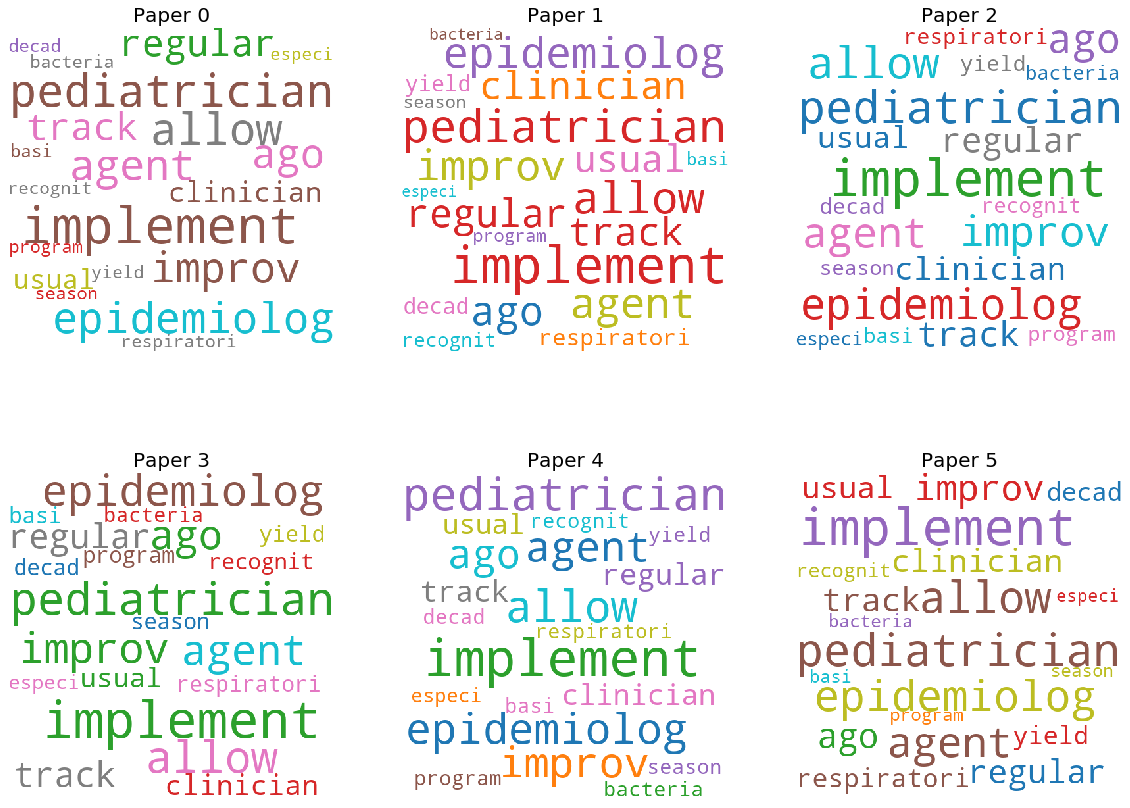

title  \
0  Monkeypox Virus Infections in Small Animal Mod...   
1  Animal Models for the Study of Neuroimmunologi...   
2                Ferret models of viral pathogenesis   
3  Virus-Induced Demyelination: From Animal Model...   
4  Modeling Approaches Toward Understanding Infec...   
5  Modelling the Epidemiology of Infectious Disea...   

                                doi       pmcid    pubmed_id  \
0                  10.3390/v2122763  PMC3185589  2.19946e+07   
1       10.1007/978-4-431-55594-0_3  PMC7122656                
2       10.1016/j.virol.2015.03.017  PMC7111696  2.58168e+07   
3     10.1016/s0025-6196(12)60833-7  PMC7125699  1.43494e+06   
4      10.1007/978-3-030-25553-4_14  PMC7121152                
5  10.2165/11539960-000000000-00000  PMC7100690  2.15042e+07   

                                 authors  
0  Hutson, Christina L.; Damon, Inger K.  
1  Croxford, J. Ludovic; Miyake, Sachiko  
2          Enkirch, T.; von Messling, V.  
3                          Rose, John W.  
4  Skrip, Laura A.; Townsend, Jeffrey P.  
5               Jit, Mark; Brisson, Marc

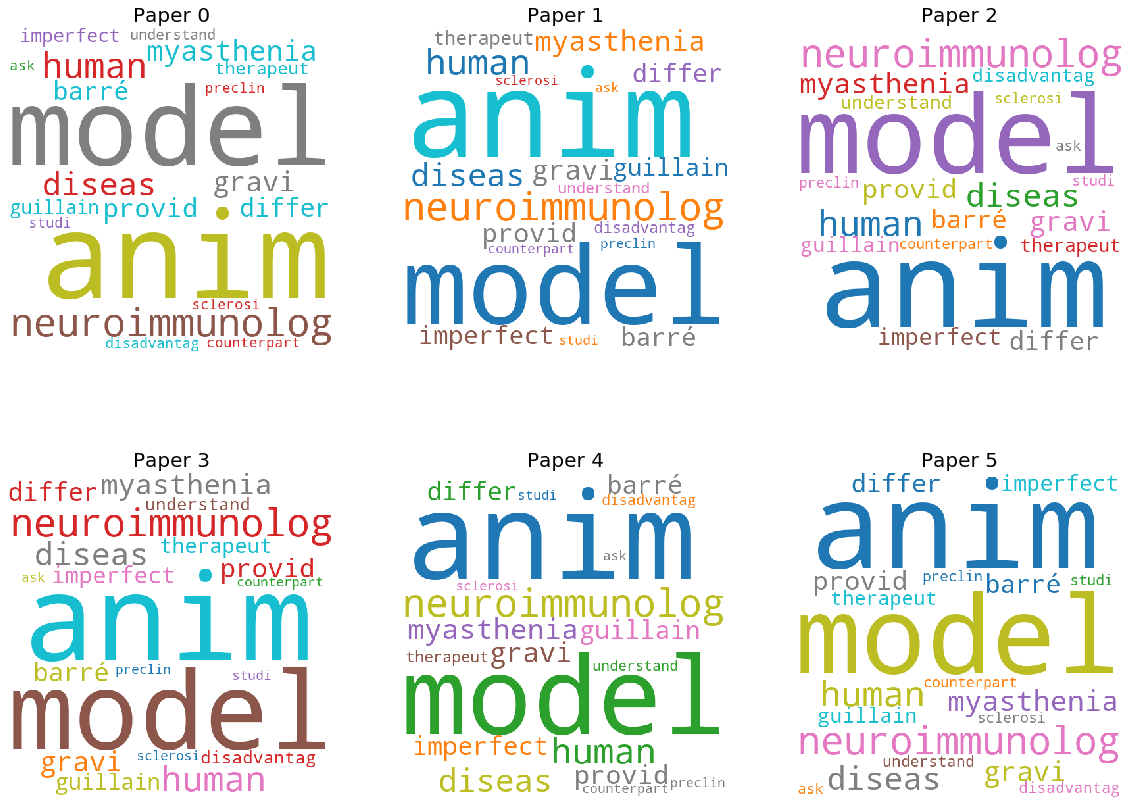

title  \
0  Moving beyond hand hygiene monitoring as a mar...   
1  Role of genomic and proteomic tools in the stu...   
2  M-VI Laboratory tools for diagnosis and monito...   
3  From genotype to phenotype: can systems biolog...   
4  A patient reported outcome platform, a useful ...   
5  Harmonising climate change adaptation and miti...   

                               doi       pmcid    pubmed_id  \
0       10.1016/j.ajic.2019.06.014  PMC7115327  3.13584e+07   
1        10.1007/s13337-013-0150-3  PMC3832694  2.44263e+07   
2    10.1016/s1386-6532(09)70033-2                            
3              10.1038/nrmicro2880  PMC7097209  2.30706e+07   
4       10.1016/j.ejca.2020.03.020  PMC7141484  3.21928e+07   
5  10.1016/j.gloenvcha.2005.08.001  PMC7127100                

                                             authors  
0  Jeanes, Annette; Coen, Pietro G.; Drey, Nicola...  
1                              Bhattacharjee, Soumen  
2                                      Kessler, H.H.  
3  Priest, Nicholas K.; Rudkin, Justine K.; Feil,...  
4  Scotté, Florian; Minvielle, Etienne; Mir, Oliv...  
5                                    Becken, Susanne

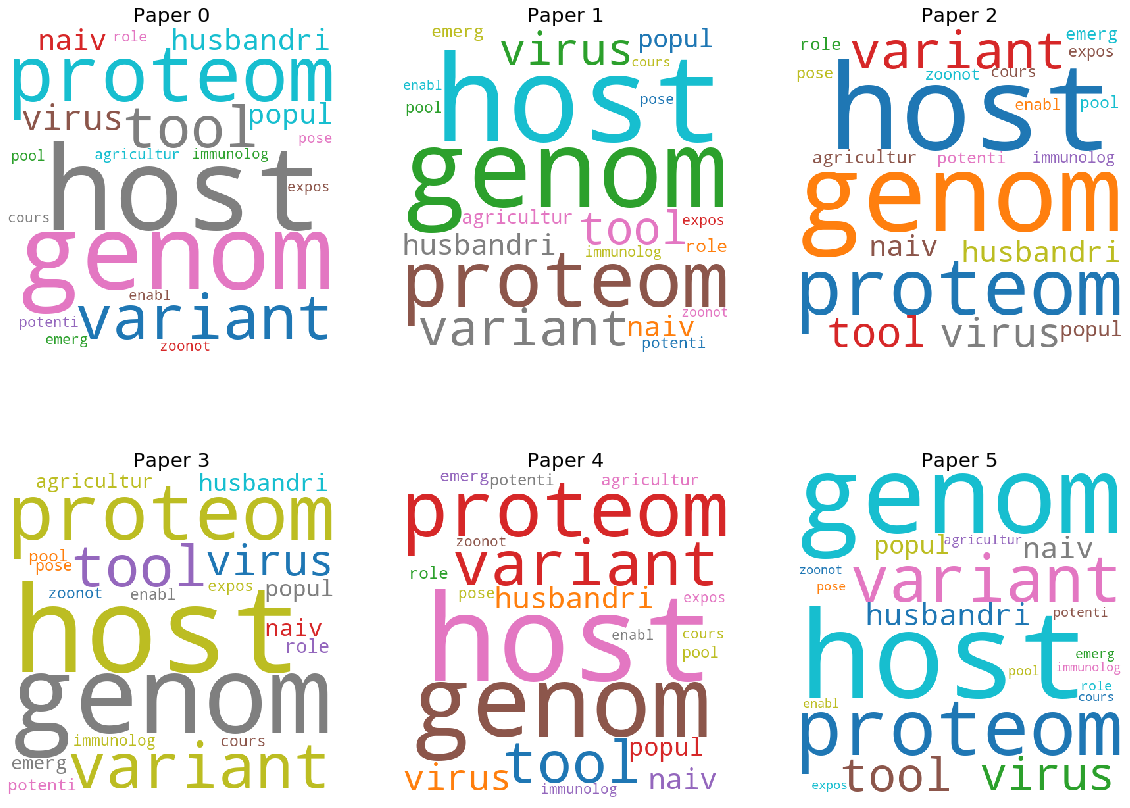

title  \
0            The immune response to virus infections   
1  Immune response of mice immunized with mouse h...   
2  Neonatal Immune Development in the Calf and It...   
3  Innate and adaptive immunity: specificities an...   
4                              Immunity to infection   
5                              Immunity to infection   

                             doi       pmcid    pubmed_id  \
0   10.1016/0165-2427(83)90059-4              6.19143e+06   
1                                                           
2     10.1016/j.cvfa.2007.11.001  PMC7127081   1.8299e+07   
3                 10.1038/ni1153  PMC7097365  1.56118e+07   
4  10.1016/s0952-7915(97)80114-8                            
5  10.1016/s0952-7915(96)80049-5              8.99824e+06   

                                             authors  
0                                       Onions, D.E.  
1         Hasony, Hassan J.; Macnaughton, Malcolm R.  
2  Chase, Christopher C.L.; Hurley, David J.; Reb...  
3                    Vivier, Eric; Malissen, Bernard  
4                                                     
5

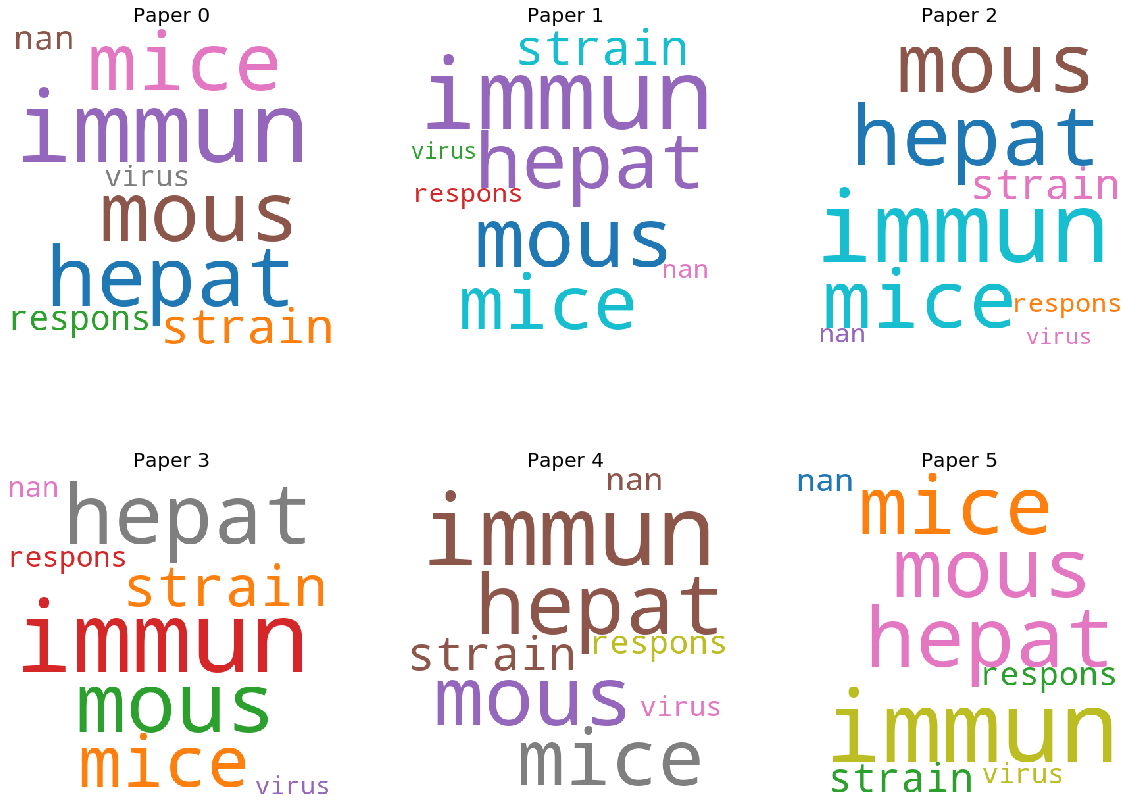

title  \
0  Using the Pillars of Infection Prevention to B...   
1  SARS transmission in Vietnam outside of the he...   
2  The Role of Managerial Epidemiology in Infecti...   
3  Contact among healthcare workers in the hospit...   
4  2007 Guideline for Isolation Precautions: Prev...   
5  Protecting health care workers from SARS and o...   

                           doi       pmcid    pubmed_id  \
0    10.1007/s40572-015-0059-7  PMC7099308  2.62315e+07   
1    10.1017/s0950268806006996  PMC2870589    1.687e+07   
2  10.1007/978-1-4419-0164-4_7  PMC7122139                
3    10.1186/s12879-018-3093-x  PMC5905140  2.96658e+07   
4   10.1016/j.ajic.2007.10.007  PMC7119119  1.80688e+07   
5   10.1016/j.ajic.2004.12.002  PMC7132691  1.57614e+07   

                                             authors  
0  Branch-Elliman, Westyn; Price, Connie Savor; B...  
1  TUAN, P. A.; HORBY, P.; DINH, P. N.; MAI, L. T...  
2                                  Oleske, Denise M.  
3  English, Krista M.; Langley, Joanne M.; McGeer...  
4  Siegel, Jane D.; Rhinehart, Emily; Jackson, Ma...  
5  Gamage, Bruce; Moore, David; Copes, Ray; Yassi...

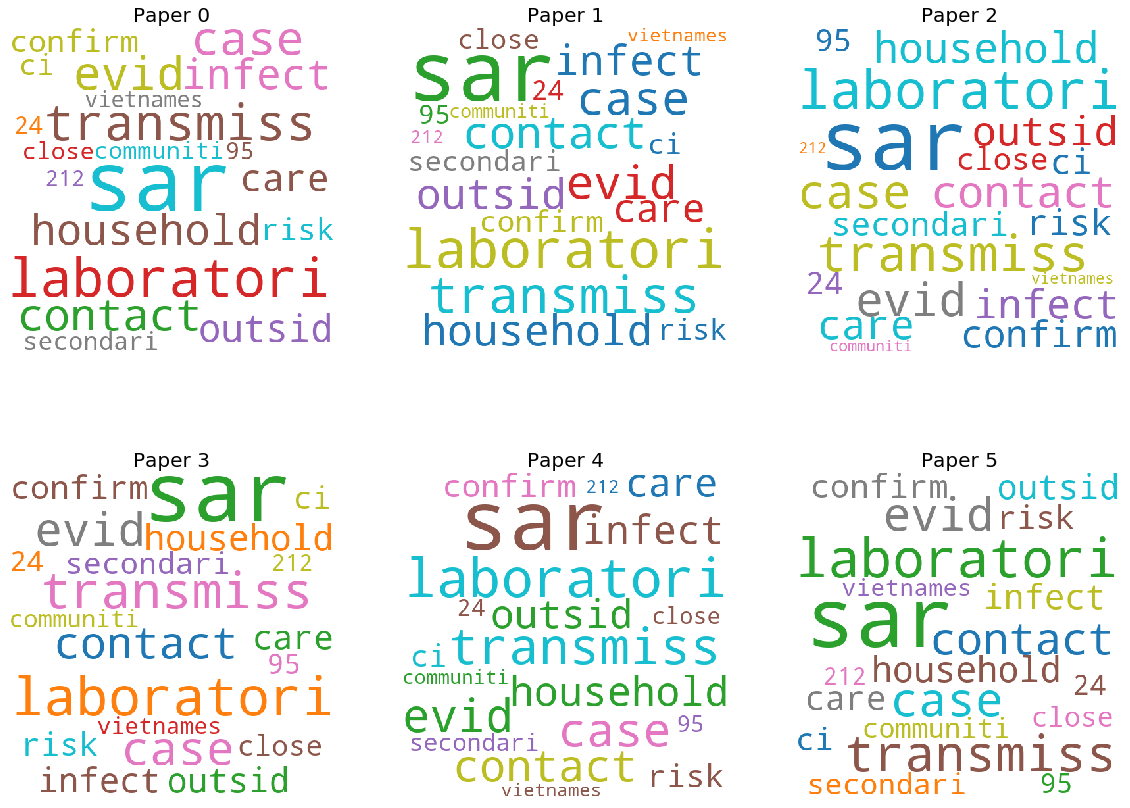

title  \
0  Variation in health care worker removal of per...   
1  Incorporating health workers’ perspectives int...   
2  Personal protective equipment in health care: ...   
3  How should front-line general practitioners us...   
4                      Personal Protective Equipment   
5  Personal Protective Equipment: Protecting Heal...   

                               doi       pmcid    pubmed_id  \
0       10.1016/j.ajic.2015.02.005  PMC7132814  2.61387e+07   
1   10.12688/f1000research.12922.2  PMC5820616  2.95273e+07   
2       10.1016/j.ajic.2008.07.007  PMC7132690  1.90842e+07   
3                                   PMC7136675                
4     10.1007/978-3-319-77032-1_14  PMC7121970                
5  10.1016/j.clinthera.2015.07.007  PMC4661082  2.64524e+07   

                                             authors  
0  Zellmer, Caroline; Van Hoof, Sarah; Safdar, Nasia  
1  Den Boon, Saskia; Vallenas, Constanza; Ferri, ...  
2  Hon, Chun-Yip; Gamage, Bruce; Bryce, Elizabeth...  
3  Ambigapathy, S; Rajahram, GS; Shamsudin, UK; K...  
4                                    Morgan, Jill S.  
5  Fischer, William A.; Weber, David J.; Wohl, Da...

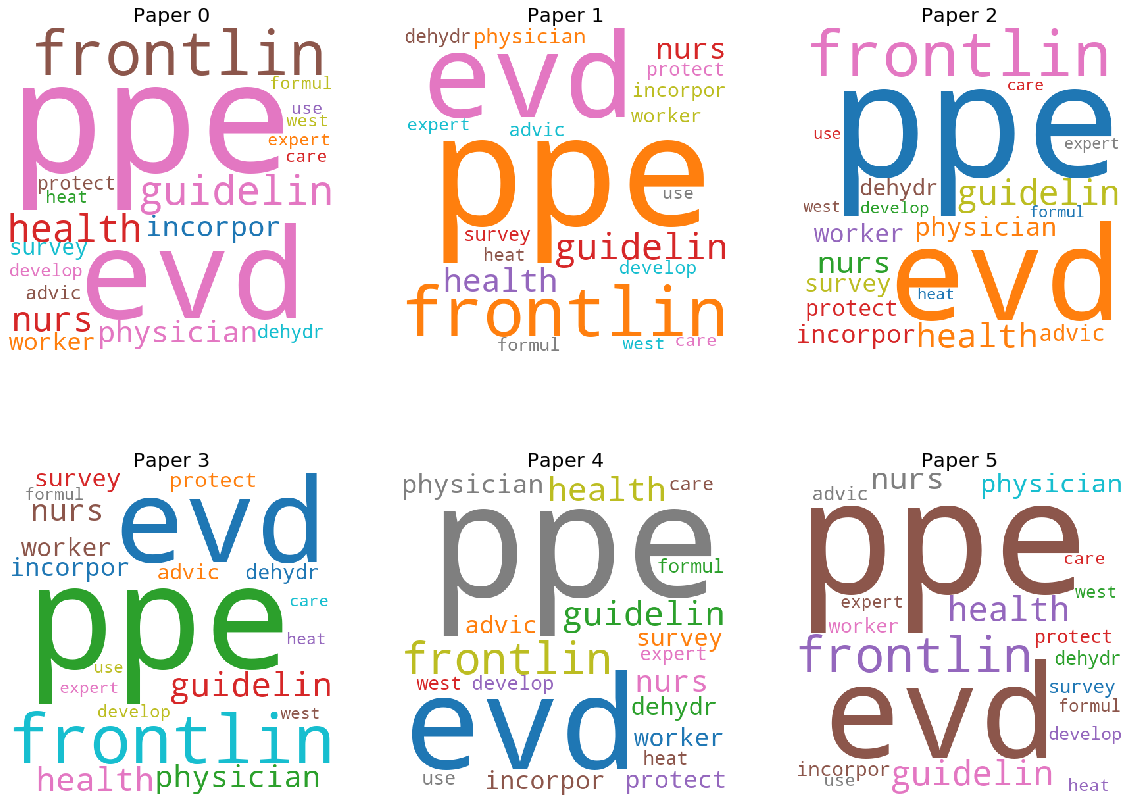

title  \
0  The Importance of the Clinical Environment in ...   
1  Closed environments facilitate secondary trans...   
2  How Behaviour and the Environment Influence Tr...   
3               Host and environment are key factors   
4   One Health: People, Animals, and the Environment   
5  The Role of the Environment and Colonization i...   

                           doi       pmcid    pubmed_id  \
0   10.1016/j.java.2015.10.002  PMC7148701                
1  10.1101/2020.02.28.20029272                            
2  10.1007/978-981-10-5287-3_2  PMC7123459                
3       10.1136/jech.57.10.770  PMC1732298  1.45736e+07   
4       10.3201/eid2204.151887  PMC4806965                
5  10.1007/978-3-319-98122-2_2  PMC7120697                

                                             authors  
0                                 Garrett, J. Hudson  
1  Hiroshi Nishiura; Hitoshi Oshitani; Tetsuro Ko...  
2      Gorochowski, Thomas E.; Richardson, Thomas O.  
3                                             Lee, A  
4                            Behravesh, Casey Barton  
5            Wohrley, Julie D.; Bartlett, Allison H.

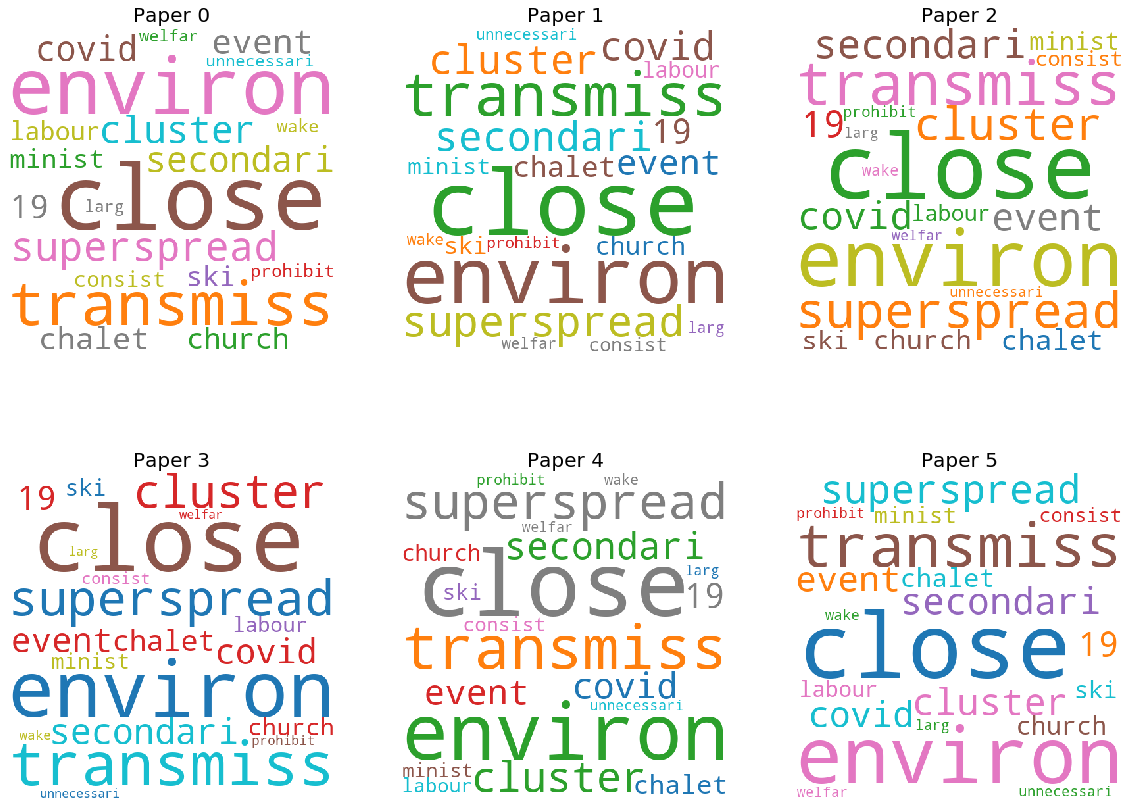

In [12]:
display_topics_results("What is known about transmission, incubation, and environmental stability?")

# What do we know about COVID-19 risk factors?

title  \
0  SARS-CoV-2 in wastewater: potential health ris...   
1  Risk factors for severe acute lower respirator...   
2  Associating Changes in the Immune System with ...   
3  Environmental Risk Factors for Stroke and Card...   
4                           Oral hygiene risk factor   
5  Risk factors for severity and mortality in pat...   

                                  doi       pmcid    pubmed_id  \
0       10.1016/s2468-1253(20)30087-x                            
1             10.3325/cmj.2013.54.110  PMC3641871  2.36301e+07   
2        10.1002/0471140856.tx1801s20  PMC7162383  2.30451e+07   
3  10.1016/b978-0-12-809657-4.64111-x  PMC7150018                
4           10.1038/s41415-020-1545-3  PMC7180644  3.23329e+07   
5           10.1007/s12250-015-3679-z  PMC7090713  2.68261e+07   

                                             authors  
0       Lodder, Willemijn; de Roda Husman, Ana Maria  
1  Jackson, Stewart; Mathews, Kyle H.; Pulanić, D...  
2  Luster, Michael I.; Germolec, Dori R.; Parks, ...  
3                   Reis, J.; Giroud, M.; Kokubo, Y.  
4                                        Sampson, V.  
5  Banik, Gouri Rani; Alqahtani, Amani Salem; Boo...

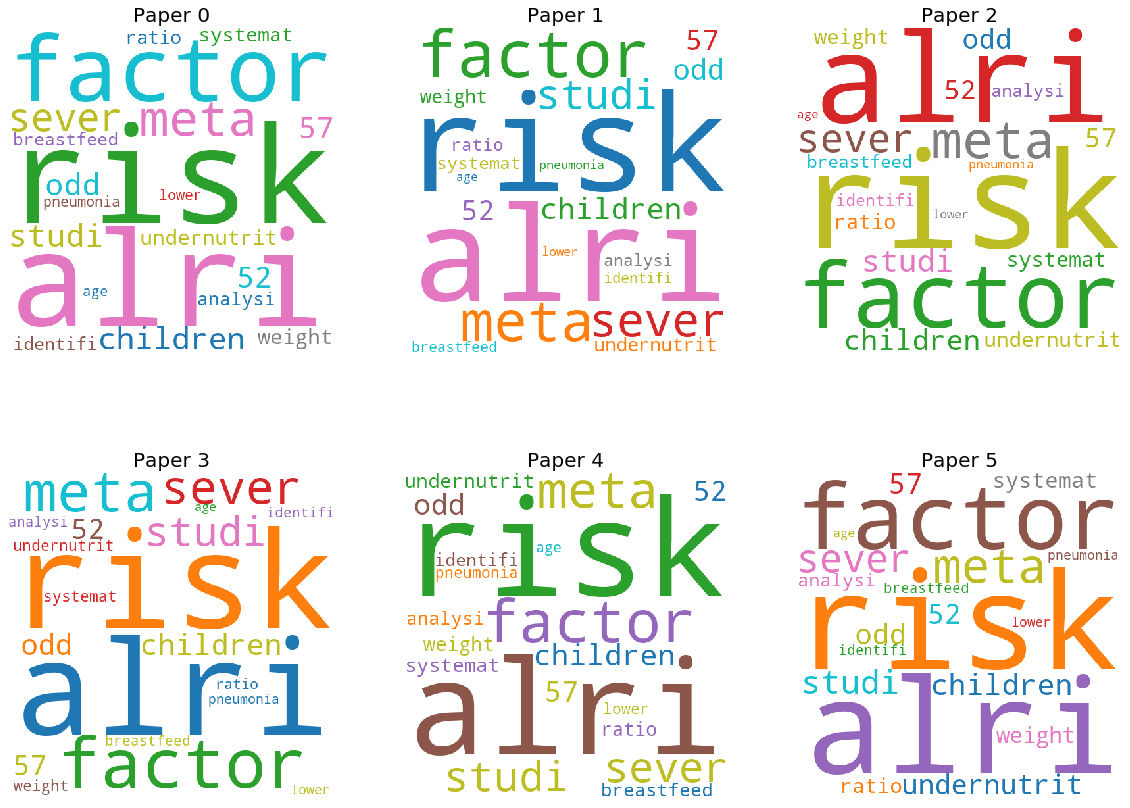

title  \
0  Losartan attenuates chronic cigarette smoke ex...   
1  Active smoking is not associated with severity...   
2  Legislative smoking bans for reducing harms fr...   
3  Role of angiotensin-converting enzyme (ACE) an...   
4  Smoking is Associated with COVID-19 Progressio...   
5  Reducing health disparity in Taiwan: quantifyi...   

                              doi       pmcid    pubmed_id  \
0      10.1016/j.taap.2010.02.009  PMC7103128  2.01788e+07   
1      10.1016/j.ejim.2020.03.014                            
2  10.1002/14651858.cd005992.pub3  PMC6486282  2.68428e+07   
3     10.1016/j.burns.2015.04.010  PMC7117055  2.59813e+07   
4     10.1101/2020.04.13.20063669                            
5          10.1136/tc.2003.005546  PMC1766179  1.59234e+07   

                                             authors  
0  Han, Su-Xia; He, Guang-Ming; Wang, Tao; Chen, ...  
1            Lippi, Giuseppe; Henry, Brandon Michael  
2  Frazer, Kate; Callinan, Joanne E; McHugh, Jack...  
3            Yilin, Zhao; Yandong, Nan; Faguang, Jin  
4          Roengrudee Patanavanich; Stanton A Glantz  
5        Cheng, T; Wen, C; Tsai, S; Chung, W; Hsu, C

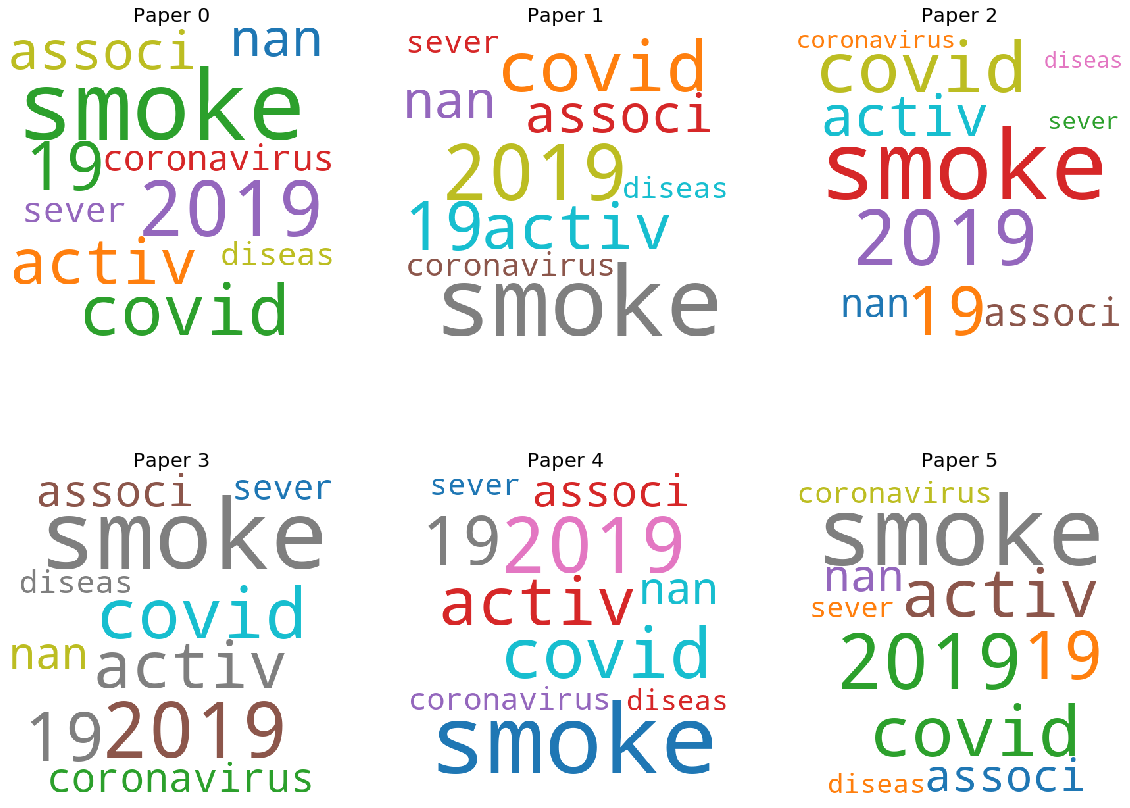

title  \
0  Tissue tropism and transmission ecology predic...   
1         28 New and Emerging Infections of the Lung   
2  Respiratory Viral Infections in Transplant Rec...   
3  A60 Revealing the evolution of virulence in RN...   
4  Transmission and Control of Respiratory Viral ...   
5    Health Care–Acquired Viral Respiratory Diseases   

                                  doi       pmcid    pubmed_id  \
0        10.1371/journal.pbio.3000206  PMC6879112  3.17704e+07   
1  10.1016/b978-0-323-44887-1.00028-6  PMC7151841                
2        10.1007/978-1-4939-9034-4_40  PMC7120918                
3               10.1093/ve/vez002.059  PMC6735695                
4           10.1007/s40506-018-0163-y  PMC7099383                
5           10.1016/j.idc.2016.07.004  PMC7125527  2.78161e+07   

                                             authors  
0  Brierley, Liam; Pedersen, Amy B.; Woolhouse, M...  
1  Tambyah, Paul; Isa, Mas Suhaila; Tan, Christel...  
2       Liu, Catherine; Ho, Dora Y.; Boeckh, Michael  
3  Escalera-Zamudio, Marina; Gutiérrez, Bernardo;...  
4             Bonvehí, Pablo E.; Temporiti, Elena R.  
5                   Dare, Ryan K.; Talbot, Thomas R.

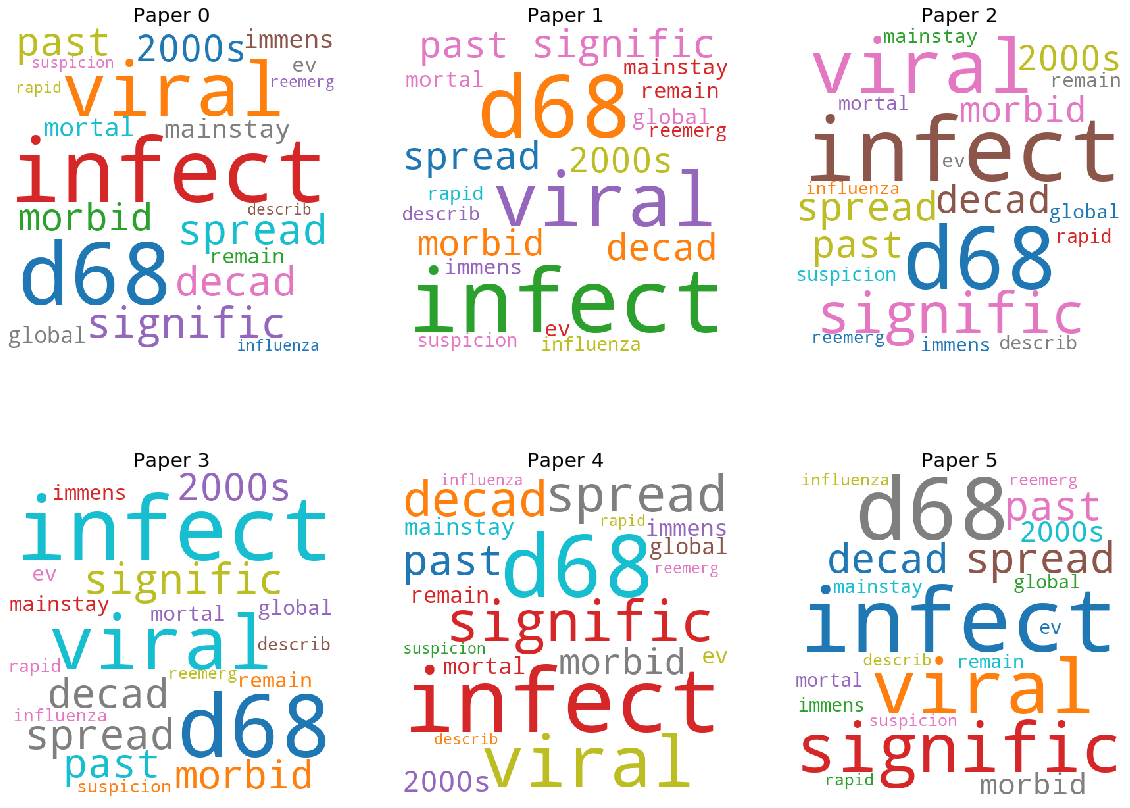

title  \
0  Clinical presentations and outcomes of SARS-Co...   
1  Clinical features and the maternal and neonata...   
2  Analysis of the pregnancy outcomes in pregnant...   
3  Pregnancy outcomes, Newborn complications and ...   
4  Maternal and neonatal outcomes of pregnant wom...   
5  Clinical characteristics of COVID-19 infection...   

                                     doi pmcid    pubmed_id  \
0             10.1016/j.scib.2020.04.040                      
1            10.1101/2020.03.22.20041061                      
2  10.3760/cma.j.cn112141-20200218-00111        3.21457e+07   
3            10.1101/2020.04.11.20062356                      
4            10.1101/2020.03.10.20033605                      
5            10.1101/2020.04.05.20053983                      

                                             authors  
0  Xu, Luming; Yang, Qianqian; Shi, Haojun; Lei, ...  
1  Rui Nie; Shao-shuai Wang; Qiong Yang; Cui-fang...  
2  Zhang, L.; Jiang, Y.; Wei, M.; Cheng, B. H.; Z...  
3          Rahul Gajbhiye; Deepak Modi; Smita Mahale  
4  Na Li; Lefei Han; Min Peng; Yuxia Lv; Yin Ouya...  
5  Sina Arabi; Golnaz Vaseghi; Zahra Heidari; Lal...

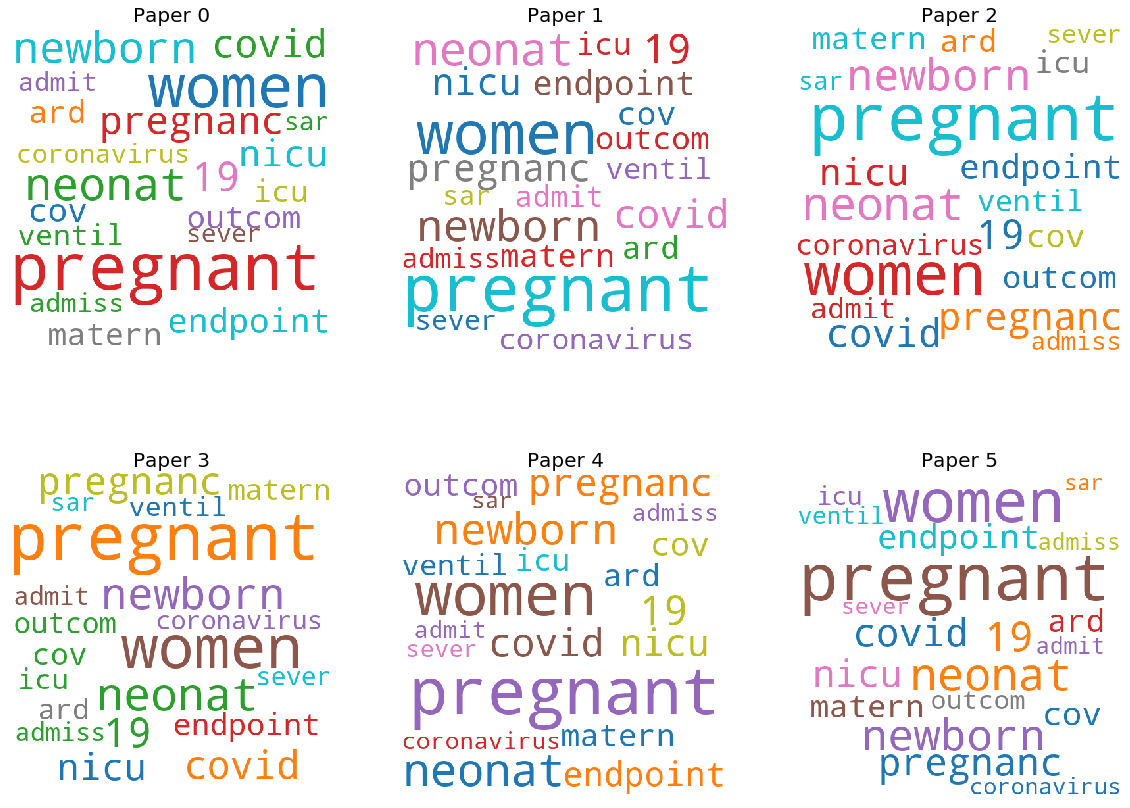

title  \
0  The socio-economic determinants of the coronav...   
1  The socio-economic determinants of the coronav...   
2  An Invited Commentary on “The Socio-Economic I...   
3  The Socio-Economic Implications of the Coronav...   
4  Merging Economics and Epidemiology to Improve ...   
5  Understanding Economic and Health Factors Impa...   

                           doi       pmcid    pubmed_id  \
0                                                         
1  10.1101/2020.04.15.20066068                            
2   10.1016/j.ijsu.2020.04.054                            
3   10.1016/j.ijsu.2020.04.018                            
4    10.1007/s10393-014-0963-6  PMC4366543  2.52338e+07   
5  10.1101/2020.04.10.20058222                            

                                             authors  
0  Viktor Stojkoski; Zoran Utkovski; Petar Jolako...  
1  Viktor Stojkoski; Zoran Utkovski; Petar Jolako...  
2                            Atar, Shaul; Atar, Itai  
3  Nicola, Maria; Alsafi, Zaid; Sohrabi, Catrin; ...  
4  Perrings, Charles; Castillo-Chavez, Carlos; Ch...  
5  Aleksandr Farseev; Yu-Yi Chu-Farseeva; Yang Qi...

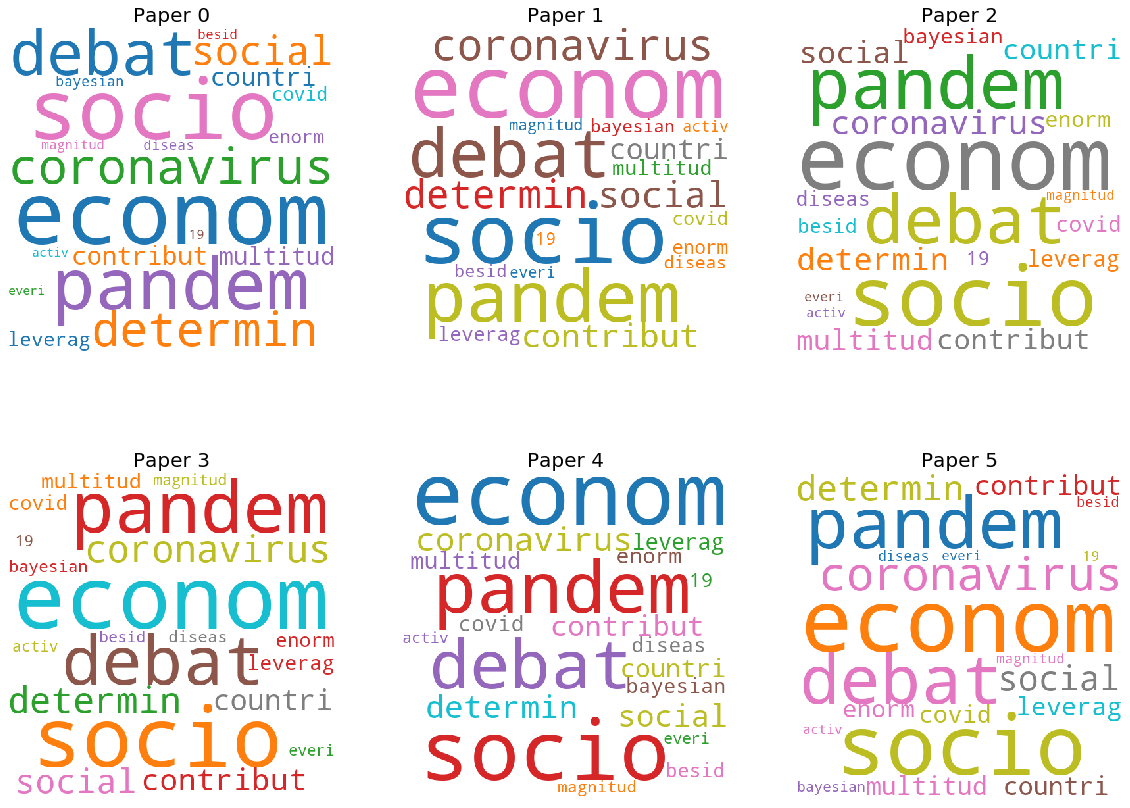

title  \
0  Transmission interval estimates suggest pre-sy...   
1  The Characteristics of Middle Eastern Respirat...   
2  Estimating the presymptomatic transmission of ...   
3    Transmissibility of swine flu at Fort Dix, 1976   
4  Time variations in the transmissibility of pan...   
5  Improved inference of time-varying reproductio...   

                            doi       pmcid    pubmed_id  \
0   10.1101/2020.03.03.20029983                            
1    10.1016/j.phrp.2016.01.001  PMC4776270  2.69813e+07   
2   10.1101/2020.04.02.20051318                            
3        10.1098/rsif.2007.0228  PMC2373398  1.74127e+07   
4        10.1186/1742-4682-4-20  PMC1892008  1.75478e+07   
5  10.1016/j.epidem.2019.100356  PMC7105007   3.1624e+07   

                                             authors  
0  Lauren Tindale; Michelle Coombe; Jessica E Sto...  
1  Kim, Yunhwan; Lee, Sunmi; Chu, Chaeshin; Choe,...  
2                                       Weituo Zhang  
3  Lessler, Justin; Cummings, Derek A.T; Fishman,...  
4                                  Nishiura, Hiroshi  
5  Thompson, R.N.; Stockwin, J.E.; van Gaalen, R....

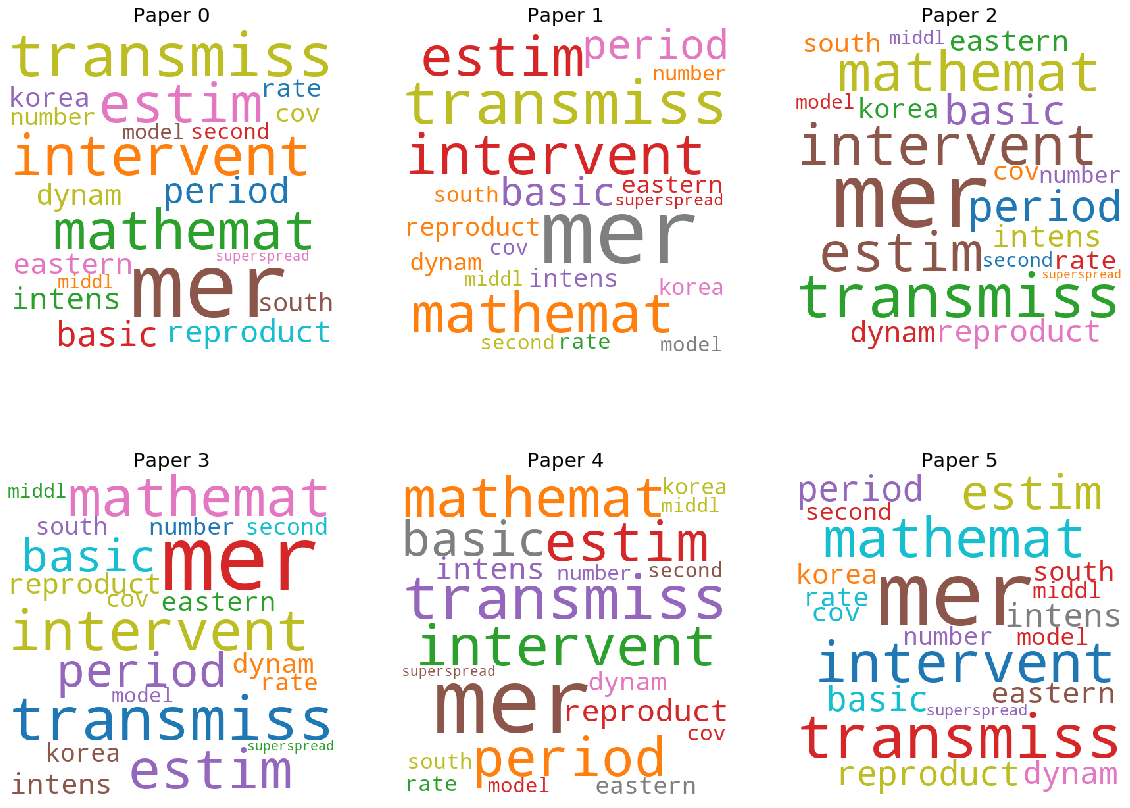

title  \
0  Human infection with avian influenza A H7N9 vi...   
1  COVID-19 Fatality and Comorbidity Risk Factors...   
2  Risk Factors Associated with Disease Severity ...   
3  Impact of respiratory virus infection in patie...   
4  Case fatality risk of novel coronavirus diseas...   
5  Real-time estimation of the hospitalization fa...   

                             doi       pmcid    pubmed_id  \
0  10.1016/s0140-6736(13)61207-6  PMC3801178  2.38035e+07   
1    10.1101/2020.04.21.20074591                            
2     10.1016/j.jinf.2020.04.008                            
3                                 PMC2271374  8.40516e+06   
4    10.1101/2020.03.04.20031005                            
5      10.1017/s0950268815003179  PMC5528870  2.71256e+07   

                                             authors  
0  Yu, Hongjie; Cowling, Benjamin J; Feng, Luzhao...  
1                      Patricio Solís; Hiram Carreňo  
2  Liu, Xiaofan; Zhou, Hong; Zhou, Yilu; Wu, Xiao...  
3  Wiselka, M. J.; Kent, J.; Cookson, J. B.; Nich...  
4  Xiaowei Deng; Juan Yang; Wei Wang; Xiling Wang...  
5  Wong, Jessica Y.; Wu, Peng; Lau, Eric H. Y.; T...

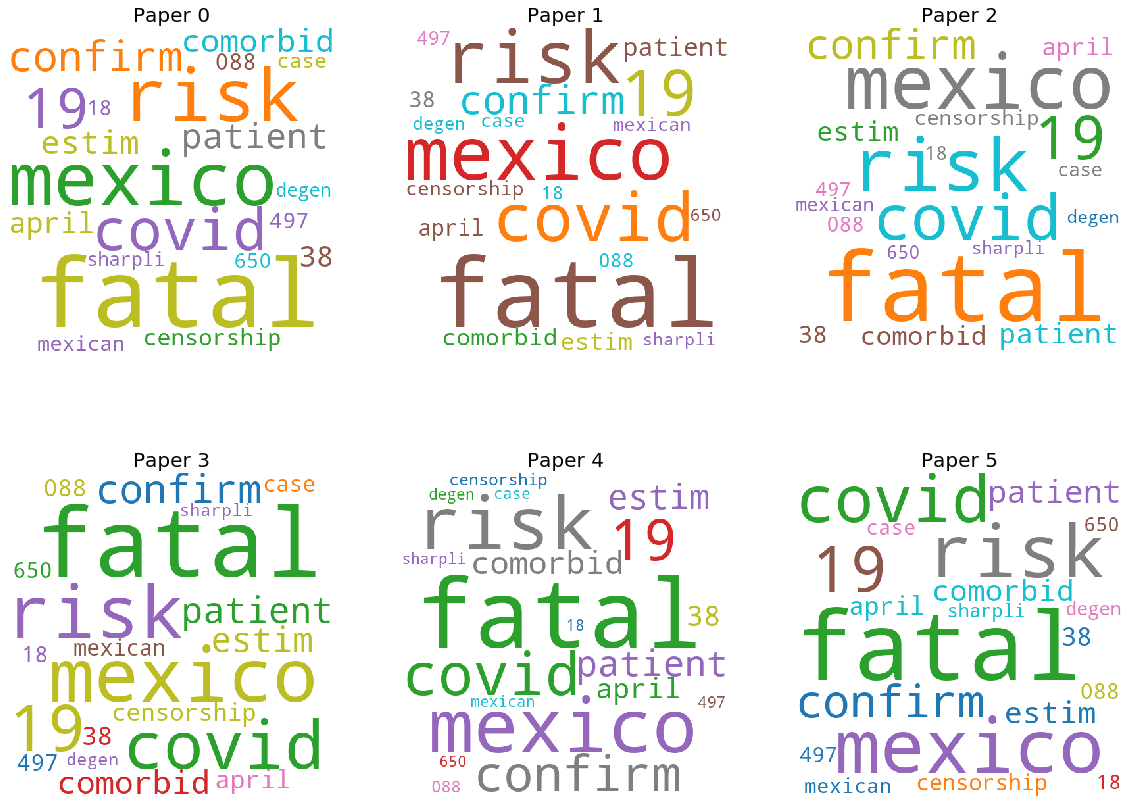

title  \
0  The final size of a SARS epidemic model withou...   
1  Disease control through removal of population ...   
2  A large-scale genomic investigation of suscept...   
3         Are children less susceptible to COVID-19?   
4               Mathematical prediction in infection   
5  COVID-19 Epidemic Dynamics and Population Proj...   

                           doi       pmcid    pubmed_id  \
0   10.1016/j.jmaa.2006.11.026  PMC7111549                
1  10.1016/j.physa.2019.123846                            
2    10.1038/s41398-019-0622-3  PMC6848113  3.17126e+07   
3   10.1016/j.jmii.2020.02.011                            
4  10.1016/j.mpmed.2009.07.004  PMC7108383                
5  10.1101/2020.04.17.20070292                            

                                             authors  
0                    Hsu, Sze-Bi; Roeger, Lih-Ing W.  
1  Senapati, Abhishek; Panday, Pijush; Samanta, S...  
2  Nudel, Ron; Wang, Yunpeng; Appadurai, Vivek; S...  
3  Lee, Ping-Ing; Hu, Ya-Li; Chen, Po-Yen; Huang,...  
4                                  Ferguson, Neil M.  
5  Rashmi Pant; Lincoln Priyadarshi Choudhry; Jam...

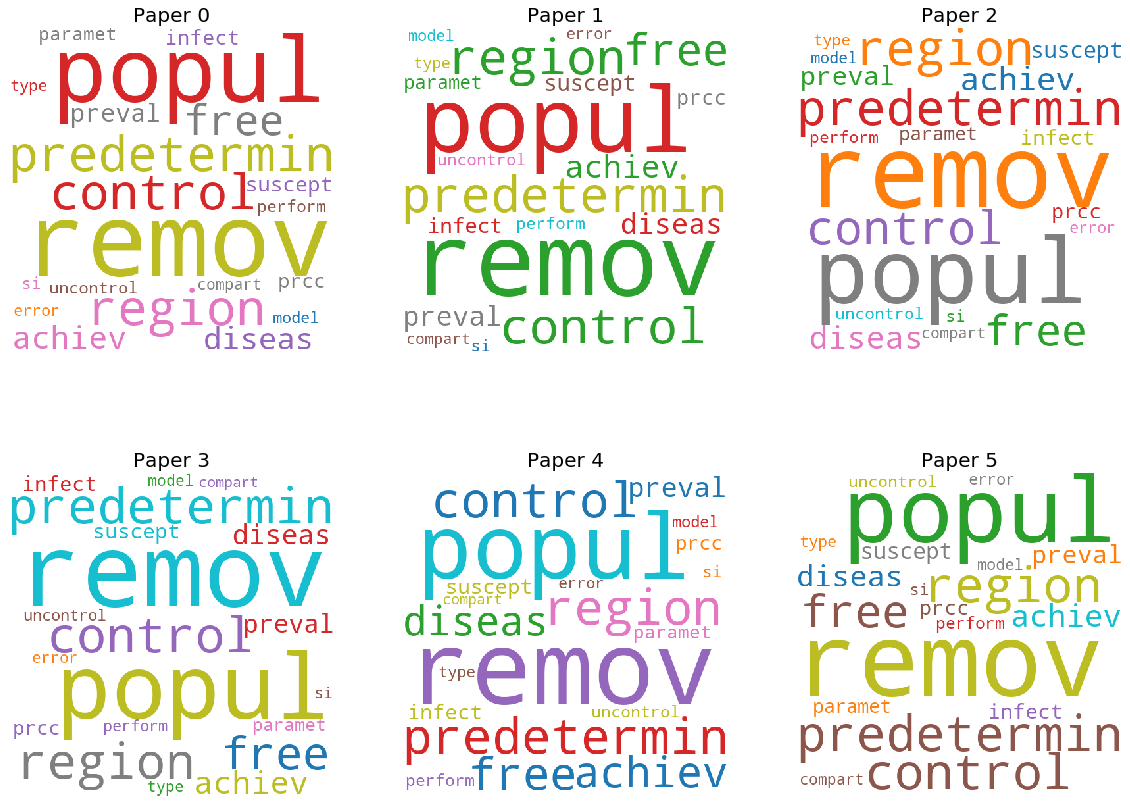

title  \
0  The value of mitigating epidemic peaks of COVI...   
1  Public Response to Community Mitigation Measur...   
2  Data Driven Modeling of Projected Mitigation a...   
3  Initial impacts of global risk mitigation meas...   
4  Extracting the effective contact rate of COVID...   
5  Survival-Convolution Models for Predicting COV...   

                           doi       pmcid    pubmed_id  \
0  10.1590/0037-8682-0135-2020  PMC7094046                
1       10.3201/eid1405.071437  PMC2600239  1.84394e+07   
2                                                         
3   10.1016/j.ssci.2020.104773                            
4                                                         
5  10.1101/2020.04.16.20067306                            

                                             authors  
0                     Villela, Daniel Antunes Maciel  
1  Blendon, Robert J.; Koonin, Lisa M.; Benson, J...  
2  Emmanuel Nimako-Aidoo de-Graft Johnson Owusu-A...  
3  Bruinen de Bruin, Yuri; Lequarre, Anne-Sophie;...  
4       Gaurav Goswami; Jayanti Prasad; Mansi Dhuria  
5  Qinxia Wang; Shanghong Xie; Yuanjia Wang; Dong...

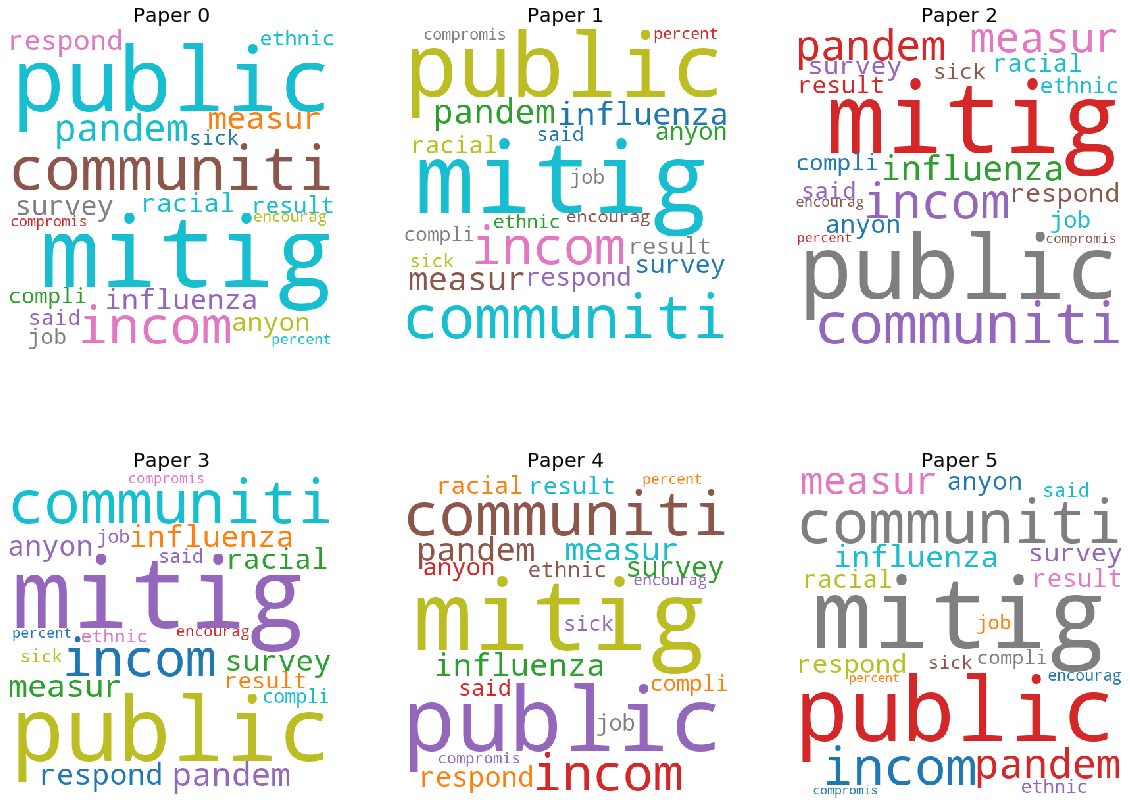

In [13]:
display_topics_results("What do we know about COVID-19 risk factors?")

# What do we know about virus genetics, origin, and evolution?

title  \
0  An interactive web-based dashboard to track CO...   
1  Tracking and visualization of space-time activ...   
2  Building an International Consortium for Track...   
3  Tracking Nosocomial Diseases at Individual Lev...   
4  A data driven time-dependent transmission rate...   
5  Towards a genomics-informed, real-time, global...   

                             doi       pmcid    pubmed_id  \
0  10.1016/s1473-3099(20)30120-1                            
1         10.1186/1476-072x-12-6  PMC3579692  2.33881e+07   
2    10.1101/2020.04.02.20051284                            
3      10.1007/s10916-018-1085-4  PMC7087895   3.0284e+07   
4     10.1016/j.scib.2020.02.005  PMC7128746                
5            10.1038/nrg.2017.88  PMC7097748  2.91299e+07   

                                             authors  
0         Dong, Ensheng; Du, Hongru; Gardner, Lauren  
1                                  Qi, Feng; Du, Fei  
2  Eran Segal; Feng Zhang; Xihong Lin; Gary King;...  
3       Cheng, Chun-Hung; Kuo, Yong-Hong; Zhou, Ziye  
4                     Huang, Norden E.; Qiao, Fangli  
5             Gardy, Jennifer L.; Loman, Nicholas J.

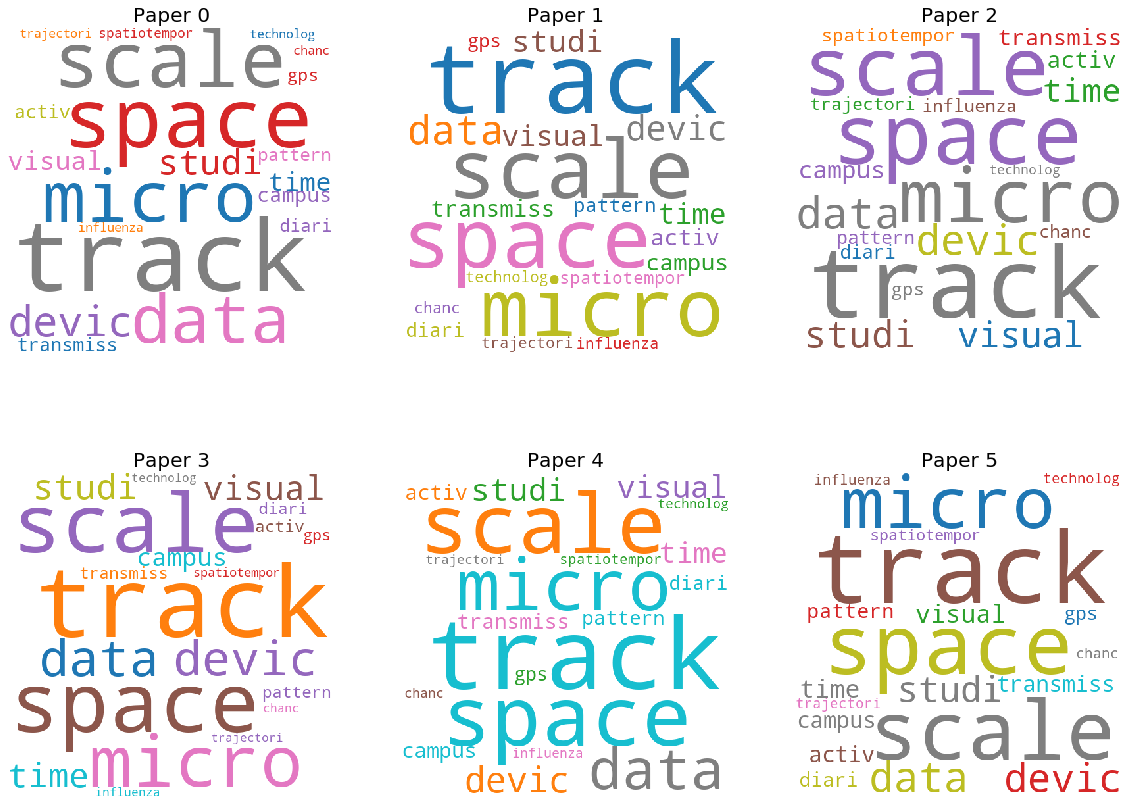

title  \
0  La sécurité sanitaire mondiale à l’heure de Na...   
1  Genomic, geographic and temporal distributions...   
2  A Cloud Based Epidemiology Network to Investig...   
3  Incorporating Geographical Contacts into Socia...   
4  Severe Acute Respiratory Syndrome: Temporal St...   
5  Descriptive review of geographic mapping of se...   

                             doi       pmcid    pubmed_id  \
0  10.1016/s0001-4079(19)30438-8  PMC7095175                
1      10.1101/2020.04.22.055863                            
2        10.1093/ofid/ofx163.500  PMC7107180                
3    10.1007/978-3-540-72608-1_3  PMC7122638                
4         10.3201/eid0908.030334  PMC3020622  1.29675e+07   
5          10.1186/1476-072x-3-2   PMC343293  1.47489e+07   

                                             authors  
0                                    Houssin, Didier  
1  Hsin-Chou Yang; Chun-houh Chen; Jen-Hung Wang;...  
2  Cook, Camille; Wallin, Andrew; Faucett, Aimie;...  
3  Chen, Yi-Da; Tseng, Chunju; King, Chwan-Chuen;...  
4  Galvani, Alison P.; Lei, Xiudong; Jewell, Nich...  
5                              Boulos, Maged N Kamel

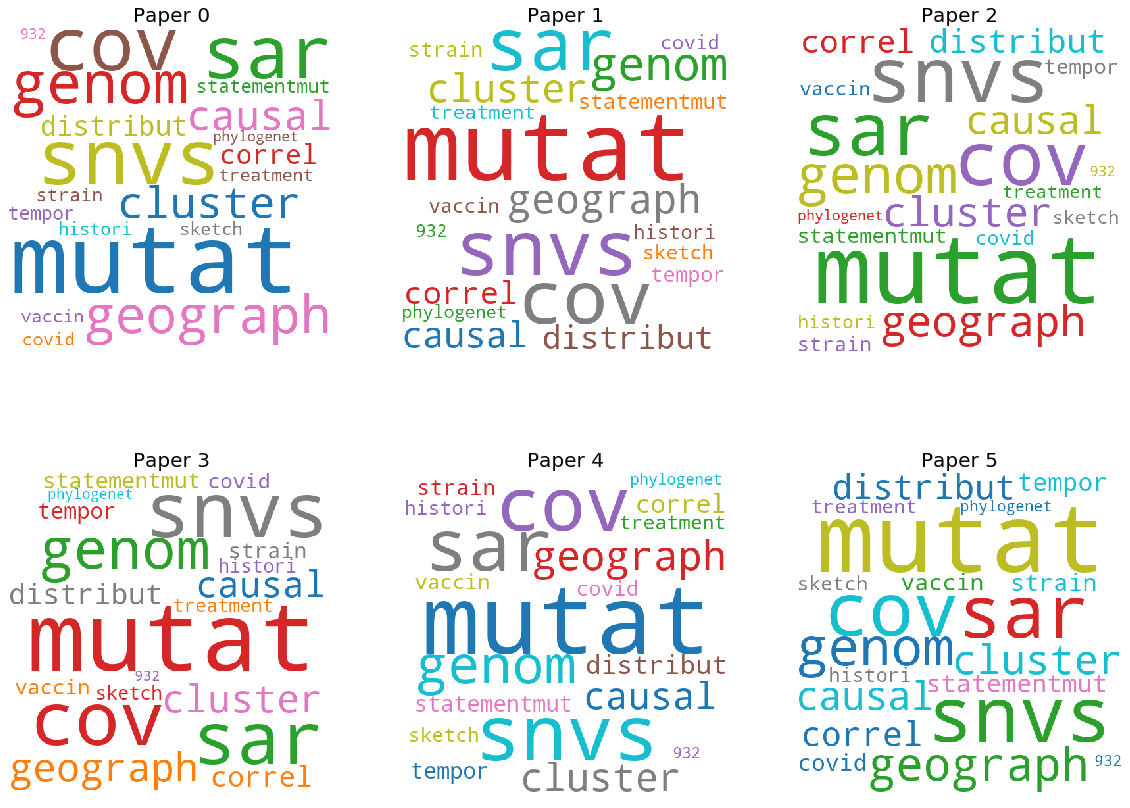

title  \
0  Pathogen genomic surveillance elucidates the o...   
1  An Ecological and Conservation Perspective on ...   
2  Predicting Reservoir Hosts and Arthropod Vecto...   
3  Middle East Respiratory Syndrome Coronavirus I...   
4  Computational simulation of interactions betwe...   
5  Discovery of Bat Coronaviruses through Surveil...   

                                  doi       pmcid   pubmed_id  \
0           10.1007/s11427-017-9211-0  PMC7088571  29270793.0   
1                    10.3390/v3040379  PMC3185704  21994738.0   
2             10.1126/science.aap9072  PMC6536379  30385576.0   
3        10.1371/journal.pone.0146251  PMC4720378  26790002.0   
4  10.1016/j.compbiolchem.2007.02.006  PMC7106403  17368104.0   
5            10.1128/msphere.00807-19  PMC6992374  31996413.0   

                                             authors  
0  Shi, Weifeng; Li, Juan; Zhou, Hong; Gao, Georg...  
1  Vandegrift, Kurt J.; Wale, Nina; Epstein, Jona...  
2  Babayan, Simon A.; Orton, Richard J.; Streicke...  
3  Borucki, Monica K.; Lao, Victoria; Hwang, Mona...  
4  Zhang, Yuan; Zheng, Nan; Nan, Peng; Cao, Ying;...  
5  Li, Bei; Si, Hao-Rui; Zhu, Yan; Yang, Xing-Lou...

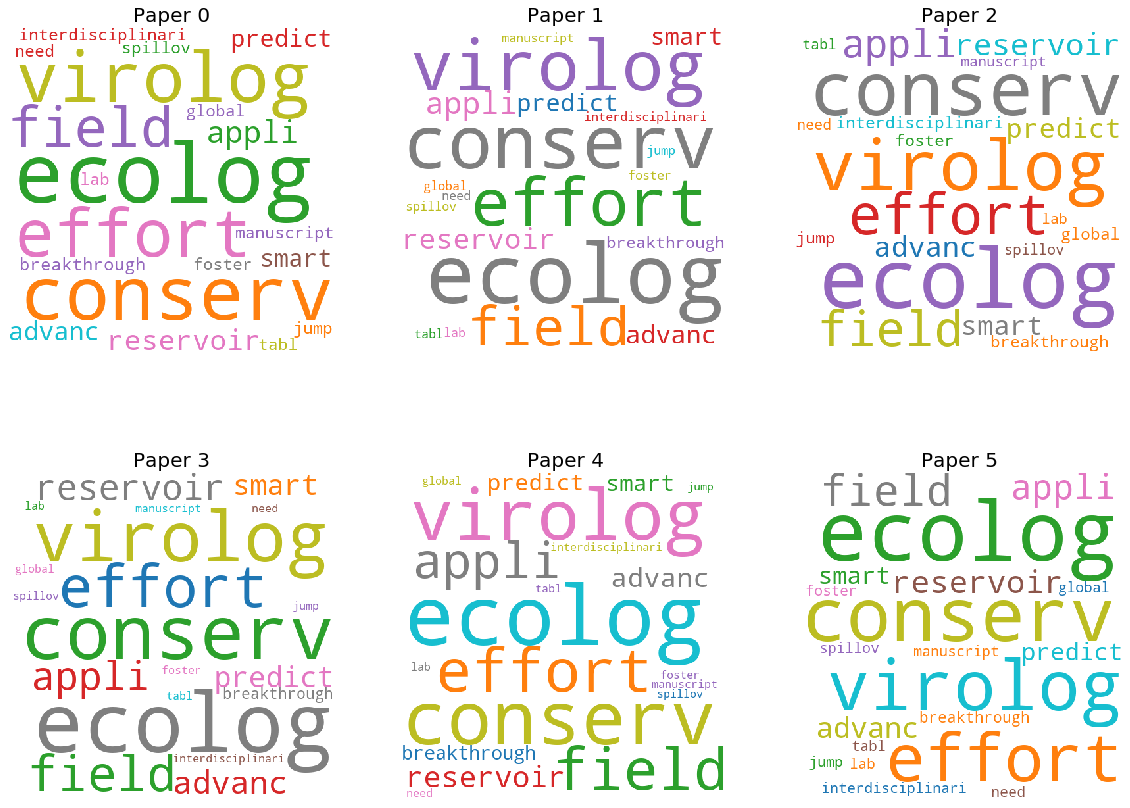

title  \
0  Comparison between dairy cow disease incidence...   
1  The Impact of Farmers’ Strategic Behavior on t...   
2  Managing Global Risks: Vietnamese Poultry Farm...   
3  Livestock diseases threatening smallholder far...   
4  Limited awareness of animal influenza preventi...   
5  Ethnoveterinary knowledge of farmers in biling...   

                               doi       pmcid    pubmed_id  \
0  10.1016/j.prevetmed.2008.12.005  PMC7114122   1.9179e+07   
1     10.1371/journal.pone.0157450  PMC4907430  2.73004e+07   
2     10.1007/978-981-287-527-3_15  PMC7120274                
3       10.1016/j.ijid.2018.11.182  PMC7128429                
4        10.1007/s11250-017-1335-3  PMC7089078  2.86249e+07   
5        10.1016/j.jep.2019.112184  PMC7185669  3.14658e+07   

                                             authors  
0  Mörk, M.; Lindberg, A.; Alenius, S.; Vågsholm,...  
1  Tago, Damian; Hammitt, James K.; Thomas, Alban...  
2                  Figué, Muriel; Desvaux, Stéphanie  
3  Pauly, M.; Xaydalasouk, K.; Innoula, N.; Snoec...  
4                         Zhao, Xiang; Davey, Gareth  
5  Mertenat, Doréane; Cero, Maja Dal; Vogl, Chris...

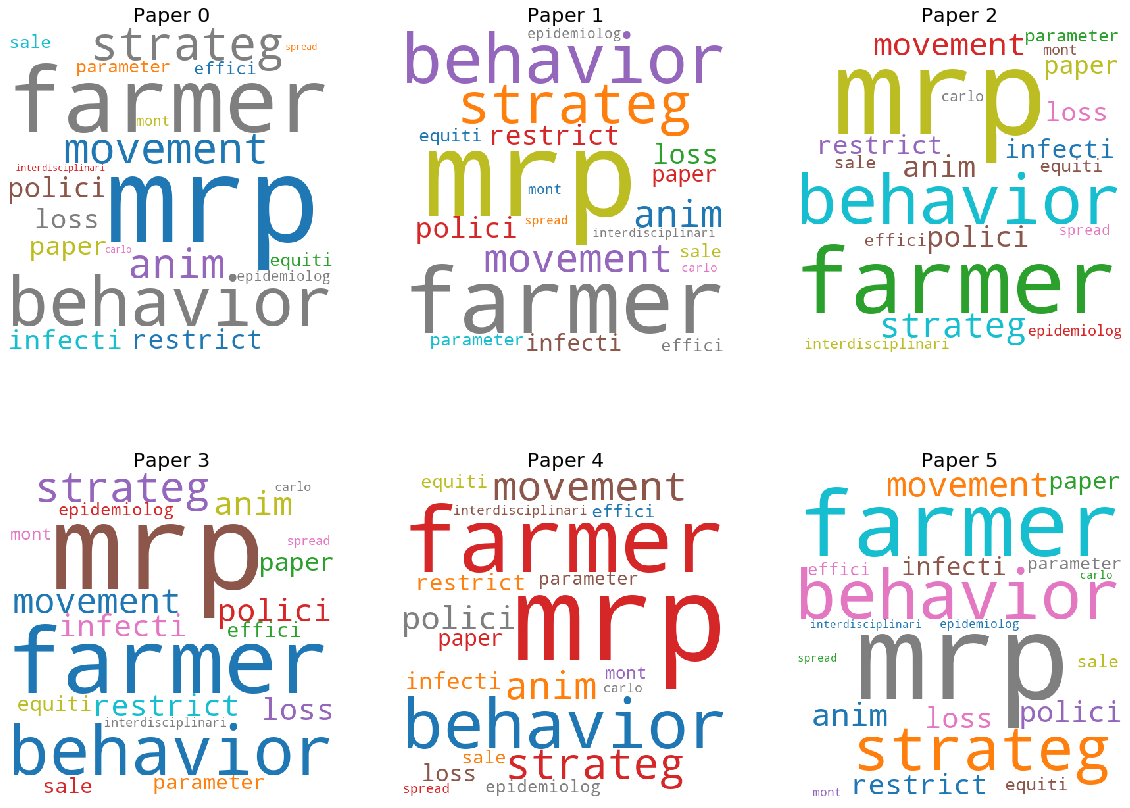

In [ ]:
display_topics_results("What do we know about virus genetics, origin, and evolution?")

# What do we know about vaccines and therapeutics?

In [ ]:
display_topics_results("What do we know about vaccines and therapeutics?")

# What do we know about diagnostics and surveillance?

In [ ]:
display_topics_results("What do we know about diagnostics and surveillance?")

#  What do we know about non-pharmaceutical interventions?

In [ ]:
display_topics_results("What do we know about non-pharmaceutical interventions?")

# What has been published about medical care?

In [ ]:
display_topics_results("What has been published about medical care?")

# What has been published about information sharing and inter-sectoral collaboration?

In [ ]:
display_topics_results("What has been published about information sharing and inter-sectoral collaboration?")

# What has been published about ethical and social science considerations?

In [ ]:
display_topics_results("What has been published about ethical and social science considerations?")

# Search friendly widget
it is not working in preview version, there are som results below.

In [ ]:
def search():
    def document_change(event):
        if not (event['type'] == 'change' and event['name'] == 'value'):
            return
        render_tab(result_tab, results.iloc[doc_select.index])

    def render_tab(tab, r):
        paper_info = widgets.VBox([widgets.Label(f"{x} : {r[x]}") for x in dict(r) if x != "word_vector"])
        keywords = widgets.Output()
        with keywords:
            plt.show(show_word_cloud(r.word_vector ))
        similiar_doc = widgets.Label("TODO")
        tab.children = [paper_info, keywords, similiar_doc]
        tab.set_title(0, "Paper info")
        tab.set_title(1, "Keywords")
        tab.set_title(2, "Similiar documents")

    def run_search(b):
        global results
        if not search_text.value:
            print("text cant be empty")
        else:
            search_widgets.layout.display = 'none'
            search_in_progress.layout.display = None
            results = get_related_documents(search_text.value, number_of_ducuments.value)
            doc_select.options = [x for x in results.title]
            search_in_progress.layout.display = 'none'
            result_widgets.layout.display = None

    search_text = widgets.Text(
        value='potential risks factors Neonates and pregnant women',
        placeholder='Search text',
        description='Search for',
        disabled=False
    )

    number_of_ducuments = widgets.IntText(
        value=5,
        description='Any:',
        disabled=False
    )

    run_button = widgets.Button(
        description='Search',
        disabled=False,
        button_style='',
        tooltip='Search',
        icon='check'
    )
    run_button.on_click(run_search)
    search_widgets = widgets.VBox([search_text, number_of_ducuments, run_button])

    search_in_progress = widgets.Label("searching...")
    search_in_progress.layout.display = 'none'
    
    doc_select = widgets.Select(
        options=[],
        description='Results',
        disabled=False
    )
    doc_select.layout.width = "90%"
    doc_select.observe(document_change)
    result_tab = widgets.Tab()
    result_widgets = widgets.VBox([doc_select, result_tab])
    result_widgets.layout.display = 'none'
    return widgets.VBox([search_widgets, search_in_progress, result_widgets])
search()

In [ ]:
Image('/kaggle/input/search-results/1.PNG')

In [ ]:
Image('/kaggle/input/search-results/2.PNG')